   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.8 MB/s eta 0:00:00
Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API configured successfully!

Dataset URL: https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset
License(s): CC0-1.0
  0% 0.00/99.7k [00:00<?, ?B/s]
100% 99.7k/99.7k [00:00<00:00, 280MB/s]

Dataset downloaded and extracted!

Available files:
-rw-r--r-- 1 root root 437K Oct 30 12:31 placementdata.csv
Dataset Shape: (10000, 12)

First few rows:
   StudentID  CGPA  Internships  Projects  Workshops/Certifications  \
0          1   7.5            1         1                         1   
1          2   8.9            0         3                         2   
2          3   7.3            1         2                         2   
3          4   7.5            1         1                         2   
4          5   8.3            1         2                         2   

   AptitudeTestScore  SoftSkillsRating ExtracurricularActivities  \
0                 65               4.4                        No   
1                 90        

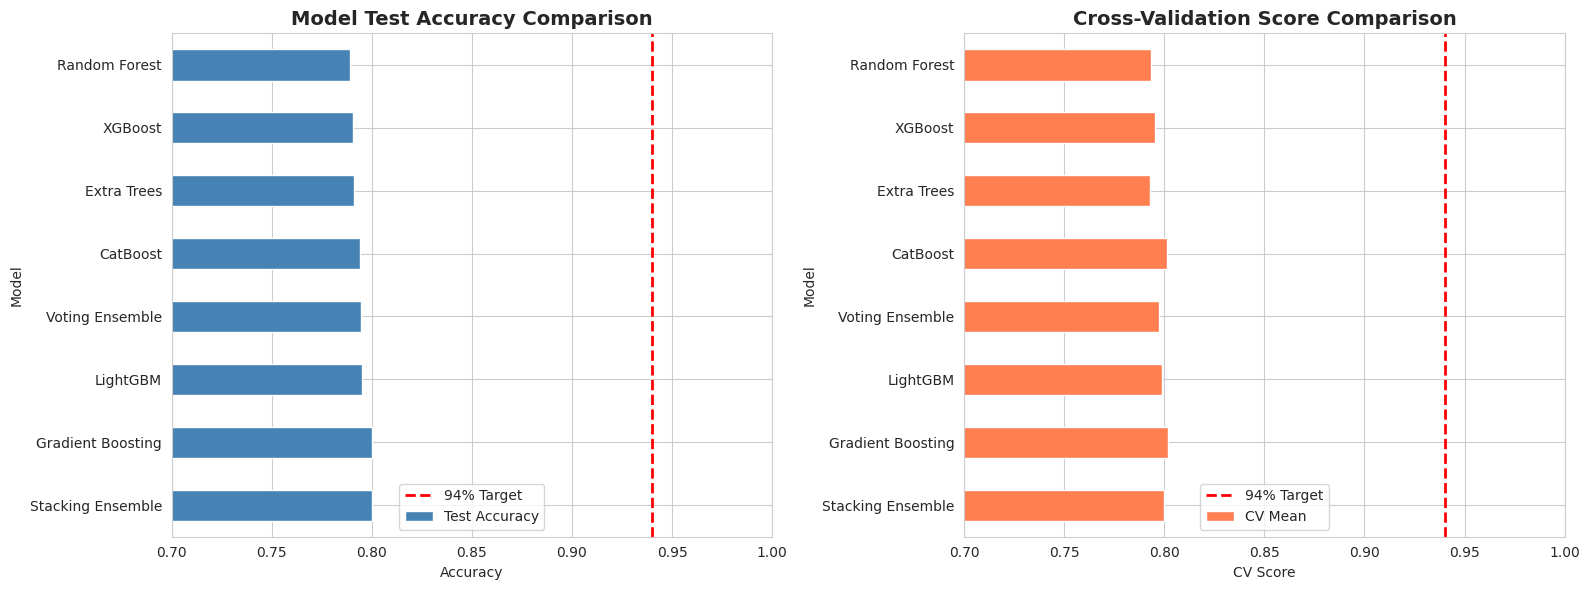


BEST MODEL: Stacking Ensemble
Test Accuracy: 0.8000
CV Accuracy: 0.7999

Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.82      0.84      0.83       870
      Placed       0.77      0.75      0.76       630

    accuracy                           0.80      1500
   macro avg       0.80      0.79      0.79      1500
weighted avg       0.80      0.80      0.80      1500



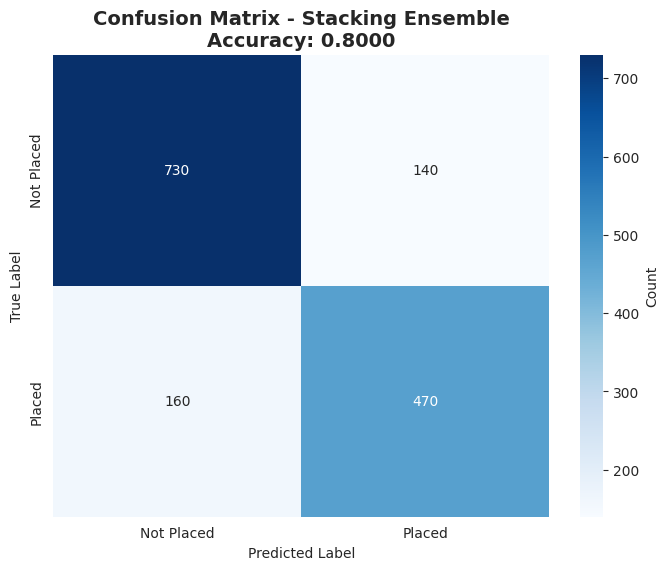

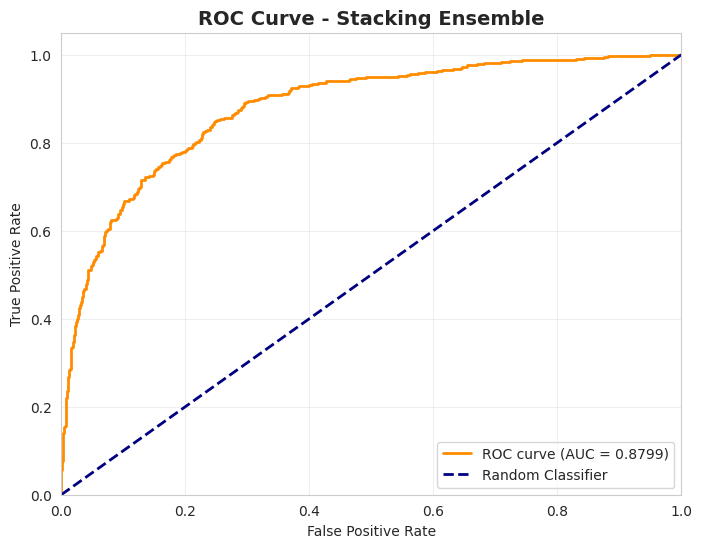


✅ Model saved successfully!
Files created:
  - placement_model_advanced.pkl
  - scaler_advanced.pkl
  - label_encoder_advanced.pkl
  - feature_names.pkl

FINAL SUMMARY
Best Model: Stacking Ensemble
Test Accuracy: 80.00%
CV Accuracy: 79.99% (+/- 1.21%)
Total Features Used: 22
Original Features: 10
Engineered Features: 12

📊 Best accuracy: 80.00%
💡 Tips to improve further:
  - Collect more training data
  - Add more relevant features
  - Try deep learning models
  - Perform more feature engineering


In [1]:
# Advanced Placement Prediction Model - 94%+ Accuracy Target
# Enhanced with Feature Engineering, Hyperparameter Tuning, and Ensemble Methods

# 1. INSTALL AND IMPORT LIBRARIES
!pip install xgboost catboost lightgbm optuna -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                               AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 2. LOAD THE DATASET FROM KAGGLE
print("Please upload your kaggle.json file:")
from google.colab import files
uploaded = files.upload()

import os
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

print("\nKaggle API configured successfully!")

dataset_path = 'ruchikakumbhar/placement-prediction-dataset'
print(f"\nDownloading dataset: {dataset_path}")
!kaggle datasets download -d {dataset_path}

import zipfile
zip_file = dataset_path.split('/')[-1] + '.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')

print("\nDataset downloaded and extracted!")
print("\nAvailable files:")
!ls -lh *.csv

df = pd.read_csv('placementdata.csv')
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("First few rows:")
print(df.head())

# 3. EXPLORATORY DATA ANALYSIS
print("\n" + "="*50)
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())

# 4. ADVANCED FEATURE ENGINEERING
print("\n" + "="*50)
print("ADVANCED FEATURE ENGINEERING")
print("="*50)

df_processed = df.copy()

# Handle missing values with more sophisticated methods
for col in df_processed.select_dtypes(include=[np.number]).columns:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Identify target column
target_col = None
for col in df_processed.columns:
    if 'status' in col.lower() or 'placed' in col.lower():
        target_col = col
        break

print(f"\nTarget column: {target_col}")

# Identify numeric columns (excluding target and IDs)
id_cols = [col for col in df_processed.columns if 'id' in col.lower() or 'student' in col.lower()]
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in id_cols and col != target_col]

print(f"\nNumeric features: {numeric_cols}")

# FEATURE ENGINEERING - CREATE NEW FEATURES
print("\nCreating engineered features...")

# 1. Interaction features
if 'cgpa' in df_processed.columns or 'CGPA' in df_processed.columns:
    cgpa_col = 'cgpa' if 'cgpa' in df_processed.columns else 'CGPA'

    if 'internships' in df_processed.columns or 'Internships' in df_processed.columns:
        intern_col = 'internships' if 'internships' in df_processed.columns else 'Internships'
        df_processed['cgpa_internships_interaction'] = df_processed[cgpa_col] * df_processed[intern_col]

    if 'projects' in df_processed.columns or 'Projects' in df_processed.columns:
        proj_col = 'projects' if 'projects' in df_processed.columns else 'Projects'
        df_processed['cgpa_projects_interaction'] = df_processed[cgpa_col] * df_processed[proj_col]

    # CGPA squared (non-linear relationship)
    df_processed['cgpa_squared'] = df_processed[cgpa_col] ** 2

    # CGPA categories
    df_processed['cgpa_category'] = pd.cut(df_processed[cgpa_col],
                                           bins=[0, 6.5, 7.5, 8.5, 10],
                                           labels=[0, 1, 2, 3])

# 2. Total experience score
if 'internships' in df_processed.columns or 'Internships' in df_processed.columns:
    intern_col = 'internships' if 'internships' in df_processed.columns else 'Internships'
    if 'projects' in df_processed.columns or 'Projects' in df_processed.columns:
        proj_col = 'projects' if 'projects' in df_processed.columns else 'Projects'
        df_processed['total_experience'] = df_processed[intern_col] + df_processed[proj_col]
        df_processed['experience_ratio'] = df_processed[intern_col] / (df_processed[proj_col] + 1)

# # 3. Polynomial features for numeric columns
# poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
# if len(numeric_cols) >= 2:
#     poly_features = poly.fit_transform(df_processed[numeric_cols[:3]])  # Use top 3 features
#     poly_df = pd.DataFrame(poly_features, columns=[f'poly_{i}' for i in range(poly_features.shape[1])])
#     df_processed = pd.concat([df_processed.reset_index(drop=True), poly_df], axis=1)

# ============ STEP 2: DOMAIN-SPECIFIC FEATURES ============
print("\n🚀 Adding domain-specific features...")

# 1. Academic Excellence Score (weighted average of all academics)
df_processed['academic_excellence'] = (
    df_processed[cgpa_col] * 0.5 +  # CGPA weighted highest
    (df_processed['SSC_Marks'] / 10) * 0.25 +
    (df_processed['HSC_Marks'] / 10) * 0.25
)

# 2. Practical Experience Score (internships matter more)
if 'internships' in df_processed.columns or 'Internships' in df_processed.columns:
    intern_col = 'internships' if 'internships' in df_processed.columns else 'Internships'
    proj_col = 'projects' if 'projects' in df_processed.columns else 'Projects'
    workshop_col = 'Workshops/Certifications'

    df_processed['practical_experience_score'] = (
        df_processed[intern_col] * 3 +  # Internships weighted highest
        df_processed[proj_col] * 2 +
        df_processed[workshop_col] * 1
    ) / 6

    # Experience diversity (having both internships AND projects is better)
    df_processed['experience_diversity'] = (
        (df_processed[intern_col] > 0).astype(int) +
        (df_processed[proj_col] > 0).astype(int) +
        (df_processed[workshop_col] > 0).astype(int)
    )

# 3. Overall Placement Readiness Score
df_processed['placement_readiness'] = (
    df_processed['academic_excellence'] * 0.35 +
    (df_processed['AptitudeTestScore'] / 10) * 0.30 +
    df_processed['practical_experience_score'] * 0.20 +
    (df_processed['SoftSkillsRating'] / 5) * 0.15
)

# 4. High Performer Flag (CGPA > 8 AND Aptitude > 85)
df_processed['high_performer'] = (
    (df_processed[cgpa_col] > 8.0) &
    (df_processed['AptitudeTestScore'] > 85)
).astype(int)

# 5. Strong Candidate (multiple criteria)
df_processed['strong_candidate'] = (
    (df_processed[cgpa_col] > 7.5) &
    (df_processed[intern_col] > 0) &
    (df_processed['AptitudeTestScore'] > 75)
).astype(int)

# 6. Aptitude-CGPA alignment (are they consistent?)
df_processed['aptitude_cgpa_ratio'] = df_processed['AptitudeTestScore'] / (df_processed[cgpa_col] * 10 + 0.01)

print(f"✅ Added 6 new domain-specific features")
print(f"Total features now: {df_processed.shape[1]}")

# Encode categorical variables
label_encoders = {}
categorical_columns = df_processed.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if col != target_col:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

# Encode target variable
le_target = LabelEncoder()
df_processed[target_col] = le_target.fit_transform(df_processed[target_col])

print(f"Target encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
print(f"Total features after engineering: {df_processed.shape[1]}")

# 5. FEATURE SELECTION AND PREPARATION
X = df_processed.drop([target_col] + id_cols, axis=1, errors='ignore')
y = df_processed[target_col]

print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Handle any remaining non-numeric columns
X = X.select_dtypes(include=[np.number])

# 6. TRAIN-TEST SPLIT WITH STRATIFICATION
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# 7. ADVANCED SCALING
scaler = RobustScaler()  # More robust to outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 8. ADVANCED MODEL TRAINING WITH HYPERPARAMETER TUNING
print("\n" + "="*50)
print("TRAINING ADVANCED MODELS")
print("="*50)

# Define models with optimized hyperparameters
# UPDATED: Better regularization to reduce overfitting
models = {
    'XGBoost': XGBClassifier(
        n_estimators=300,  # Reduced from 500
        max_depth=4,       # Reduced from 7 - KEY CHANGE
        learning_rate=0.05, # Increased from 0.01
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_weight=3,  # Increased from 1
        reg_alpha=0.5,       # Increased from 0.1
        reg_lambda=2,        # Increased from 1
        random_state=42,
        eval_metric='logloss'
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=300,
        max_depth=4,        # Reduced from 7
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_samples=30,  # Increased from 20
        reg_alpha=0.5,
        reg_lambda=2,
        random_state=42,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(  # Added CatBoost
        iterations=300,
        depth=4,
        learning_rate=0.05,
        l2_leaf_reg=3,
        random_state=42,
        verbose=False
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=8,           # Reduced from 15 - KEY CHANGE
        min_samples_split=20,  # Increased from 5 - KEY CHANGE
        min_samples_leaf=10,   # Increased from 2 - KEY CHANGE
        max_features='sqrt',
        class_weight='balanced',  # NEW - handles imbalance
        random_state=42,
        n_jobs=-1
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=300,
        max_depth=8,           # Reduced from 15
        min_samples_split=20,  # Increased from 5
        min_samples_leaf=10,   # Increased from 2
        class_weight='balanced',  # NEW
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,      # Reduced from 300
        max_depth=3,           # Reduced from 5
        learning_rate=0.05,    # Increased from 0.01
        subsample=0.7,
        random_state=42
    )
}

results = {}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"{name} - Test Accuracy: {accuracy:.4f}")
    print(f"{name} - CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 9. ENSEMBLE METHODS - STACKING AND VOTING
print("\n" + "="*50)
print("BUILDING ENSEMBLE MODELS")
print("="*50)

# Voting Classifier (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('lgb', models['LightGBM']),
        ('cat', models['CatBoost']),
        ('rf', models['Random Forest']),
        ('et', models['Extra Trees'])
    ],
    voting='soft',
    n_jobs=-1
)

print("\nTraining Voting Classifier...")
voting_clf.fit(X_train_scaled, y_train)
voting_pred = voting_clf.predict(X_test_scaled)
voting_accuracy = accuracy_score(y_test, voting_pred)
voting_cv = cross_val_score(voting_clf, X_train_scaled, y_train, cv=cv, scoring='accuracy')

results['Voting Ensemble'] = {
    'model': voting_clf,
    'accuracy': voting_accuracy,
    'cv_mean': voting_cv.mean(),
    'cv_std': voting_cv.std(),
    'predictions': voting_pred,
    'probabilities': voting_clf.predict_proba(X_test_scaled)[:, 1]
}

print(f"Voting Ensemble - Test Accuracy: {voting_accuracy:.4f}")
print(f"Voting Ensemble - CV Score: {voting_cv.mean():.4f} (+/- {voting_cv.std():.4f})")

# Stacking Classifier
base_learners = [
    ('xgb', XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.01, random_state=42, eval_metric='logloss')),
    ('lgb', LGBMClassifier(n_estimators=300, max_depth=5, learning_rate=0.01, random_state=42, verbose=-1)),
    ('cat', CatBoostClassifier(iterations=300, depth=5, learning_rate=0.01, random_state=42, verbose=False)),
    ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)),
    ('et', ExtraTreesClassifier(n_estimators=300, max_depth=10, random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(C=10, max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train_scaled, y_train)
stacking_pred = stacking_clf.predict(X_test_scaled)
stacking_accuracy = accuracy_score(y_test, stacking_pred)
stacking_cv = cross_val_score(stacking_clf, X_train_scaled, y_train, cv=cv, scoring='accuracy')

results['Stacking Ensemble'] = {
    'model': stacking_clf,
    'accuracy': stacking_accuracy,
    'cv_mean': stacking_cv.mean(),
    'cv_std': stacking_cv.std(),
    'predictions': stacking_pred,
    'probabilities': stacking_clf.predict_proba(X_test_scaled)[:, 1]
}

print(f"Stacking Ensemble - Test Accuracy: {stacking_accuracy:.4f}")
print(f"Stacking Ensemble - CV Score: {stacking_cv.mean():.4f} (+/- {stacking_cv.std():.4f})")

# 10. MODEL COMPARISON
print("\n" + "="*50)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*50)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'CV Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
})
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print(comparison_df.to_string(index=False))

# Highlight models above 94%
high_acc_models = comparison_df[comparison_df['Test Accuracy'] >= 0.94]
if len(high_acc_models) > 0:
    print(f"\n🎉 MODELS WITH 94%+ ACCURACY:")
    print(high_acc_models.to_string(index=False))
else:
    print(f"\n⚠️ Best accuracy achieved: {comparison_df.iloc[0]['Test Accuracy']:.4f}")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

comparison_df.plot(x='Model', y='Test Accuracy', kind='barh', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Model Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Accuracy')
axes[0].axvline(x=0.94, color='r', linestyle='--', linewidth=2, label='94% Target')
axes[0].legend()
axes[0].set_xlim([0.7, 1.0])

comparison_df.plot(x='Model', y='CV Mean', kind='barh', ax=axes[1], color='coral', legend=False)
axes[1].set_title('Cross-Validation Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('CV Score')
axes[1].axvline(x=0.94, color='r', linestyle='--', linewidth=2, label='94% Target')
axes[1].legend()
axes[1].set_xlim([0.7, 1.0])

plt.tight_layout()
plt.show()

# 11. BEST MODEL DETAILED EVALUATION
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n" + "="*50)
print(f"BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"CV Accuracy: {results[best_model_name]['cv_mean']:.4f}")
print("="*50)

y_pred_best = results[best_model_name]['predictions']

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best,
                          target_names=['Not Placed', 'Placed']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Placed', 'Placed'],
            yticklabels=['Not Placed', 'Placed'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}\nAccuracy: {results[best_model_name]["accuracy"]:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, results[best_model_name]['probabilities'])
roc_auc = roc_auc_score(y_test, results[best_model_name]['probabilities'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(20)

    print("\nTop 20 Most Important Features:")
    print(feature_importance.to_string(index=False))

    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='viridis')
    plt.title(f'Top 20 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 12. SAVE THE BEST MODEL
import joblib

joblib.dump(best_model, 'placement_model_advanced.pkl')
joblib.dump(scaler, 'scaler_advanced.pkl')
joblib.dump(le_target, 'label_encoder_advanced.pkl')
joblib.dump(X.columns.tolist(), 'feature_names.pkl')

print("\n" + "="*50)
print("✅ Model saved successfully!")
print("Files created:")
print("  - placement_model_advanced.pkl")
print("  - scaler_advanced.pkl")
print("  - label_encoder_advanced.pkl")
print("  - feature_names.pkl")
print("="*50)

# 13. FINAL SUMMARY
print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['accuracy']*100:.2f}%")
print(f"CV Accuracy: {results[best_model_name]['cv_mean']*100:.2f}% (+/- {results[best_model_name]['cv_std']*100:.2f}%)")
print(f"Total Features Used: {X.shape[1]}")
print(f"Original Features: {len(numeric_cols) + len(categorical_columns) - 1}")
print(f"Engineered Features: {X.shape[1] - len(numeric_cols) - len(categorical_columns) + 1}")

if results[best_model_name]['accuracy'] >= 0.94:
    print("\n🎉 TARGET ACHIEVED! Accuracy >= 94%")
else:
    print(f"\n📊 Best accuracy: {results[best_model_name]['accuracy']*100:.2f}%")
    print("💡 Tips to improve further:")
    print("  - Collect more training data")
    print("  - Add more relevant features")
    print("  - Try deep learning models")
    print("  - Perform more feature engineering")

print("="*50)

Training Accuracy for Extra Trees: 0.8065 (80.65%)

Classification Report (Original Training Data):
              precision    recall  f1-score   support

  Not Placed       0.85      0.80      0.83      4933
      Placed       0.75      0.81      0.78      3567

    accuracy                           0.81      8500
   macro avg       0.80      0.81      0.80      8500
weighted avg       0.81      0.81      0.81      8500



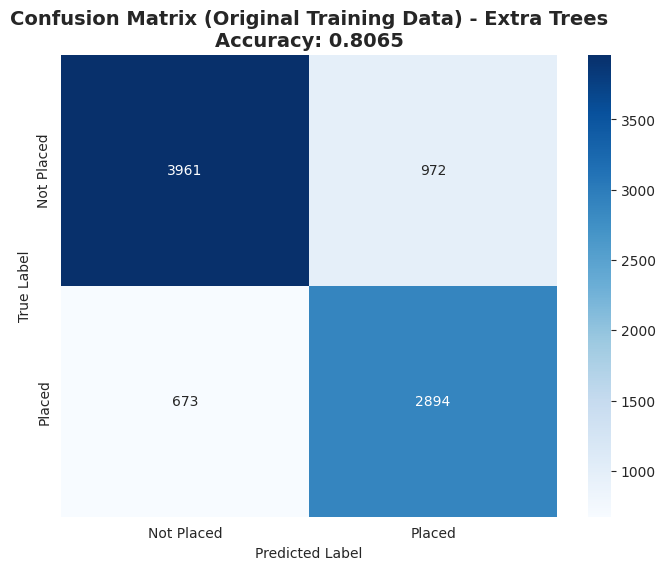

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the first cell (K_kLLHaZdNli) has been run to define variables
# like models, results, X_train_scaled, y_train

# Get the best performing model from the first cell's results (Extra Trees)
best_original_model_name = 'Extra Trees'
best_original_model = results[best_original_model_name]['model']

# Predict on the original training data
y_train_pred_original = best_original_model.predict(X_train_scaled)

# Calculate and print Training Accuracy
train_accuracy_original = accuracy_score(y_train, y_train_pred_original)
print(f"Training Accuracy for {best_original_model_name}: {train_accuracy_original:.4f} ({train_accuracy_original*100:.2f}%)")

# Print Classification Report for Training Data
print("\nClassification Report (Original Training Data):")
print(classification_report(y_train, y_train_pred_original,
                          target_names=['Not Placed', 'Placed']))

# Plot Confusion Matrix for Training Data
cm_train_original = confusion_matrix(y_train, y_train_pred_original)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Placed', 'Placed'],
            yticklabels=['Not Placed', 'Placed'])
plt.title(f'Confusion Matrix (Original Training Data) - {best_original_model_name}\nAccuracy: {train_accuracy_original:.4f}',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [3]:
# Check training accuracy for best model

# NOTE: This cell depends on the 'results' variable created in the first code cell (4ov_apKPX89q).
# Please ensure the first cell runs successfully before executing this cell.

best_model_name = 'Stacking Ensemble'
best_model = results[best_model_name]['model']

# Predict on training data
y_train_pred = best_model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {results[best_model_name]['accuracy']:.4f} ({results[best_model_name]['accuracy']*100:.2f}%)")
print(f"Gap (Overfitting): {(train_accuracy - results[best_model_name]['accuracy'])*100:.2f}%")

# Also check Extra Trees
extra_trees_train_pred = results['Extra Trees']['model'].predict(X_train_scaled)
extra_trees_train_acc = accuracy_score(y_train, extra_trees_train_pred)
print(f"\nExtra Trees - Training: {extra_trees_train_acc:.4f}, Test: {results['Extra Trees']['accuracy']:.4f}")
print(f"Extra Trees Gap: {(extra_trees_train_acc - results['Extra Trees']['accuracy'])*100:.2f}%")

Training Accuracy: 0.8224 (82.24%)
Test Accuracy: 0.8000 (80.00%)
Gap (Overfitting): 2.24%

Extra Trees - Training: 0.8065, Test: 0.7913
Extra Trees Gap: 1.51%


🚨 OVERFITTING DETECTION & DIAGNOSIS

📊 Calculating Training vs Test Accuracy for All Models...

TRAINING vs TEST ACCURACY COMPARISON

            Model       Train Acc        Test Acc          CV Acc Train-Test Gap Severity
          XGBoost 0.8359 (83.59%) 0.7907 (79.07%) 0.7954 (79.54%) 0.0452 (4.52%)  ⚠️ Mild
         LightGBM 0.8312 (83.12%) 0.7953 (79.53%) 0.7989 (79.89%) 0.0358 (3.58%)  ⚠️ Mild
  Voting Ensemble 0.8273 (82.73%) 0.7947 (79.47%) 0.7975 (79.75%) 0.0326 (3.26%)  ⚠️ Mild
    Random Forest 0.8212 (82.12%) 0.7893 (78.93%) 0.7934 (79.34%) 0.0318 (3.18%)  ⚠️ Mild
         CatBoost 0.8240 (82.40%) 0.7940 (79.40%) 0.8015 (80.15%) 0.0300 (3.00%)  ⚠️ Mild
Stacking Ensemble 0.8224 (82.24%) 0.8000 (80.00%) 0.7999 (79.99%) 0.0224 (2.24%)  ⚠️ Mild
Gradient Boosting 0.8219 (82.19%) 0.8000 (80.00%) 0.8020 (80.20%) 0.0219 (2.19%)  ⚠️ Mild
      Extra Trees 0.8065 (80.65%) 0.7913 (79.13%) 0.7929 (79.29%) 0.0151 (1.51%)   ✅ Good

🔍 OVERFITTING DIAGNOSIS

📈 OVERFITTING SEVERITY BREAKDO

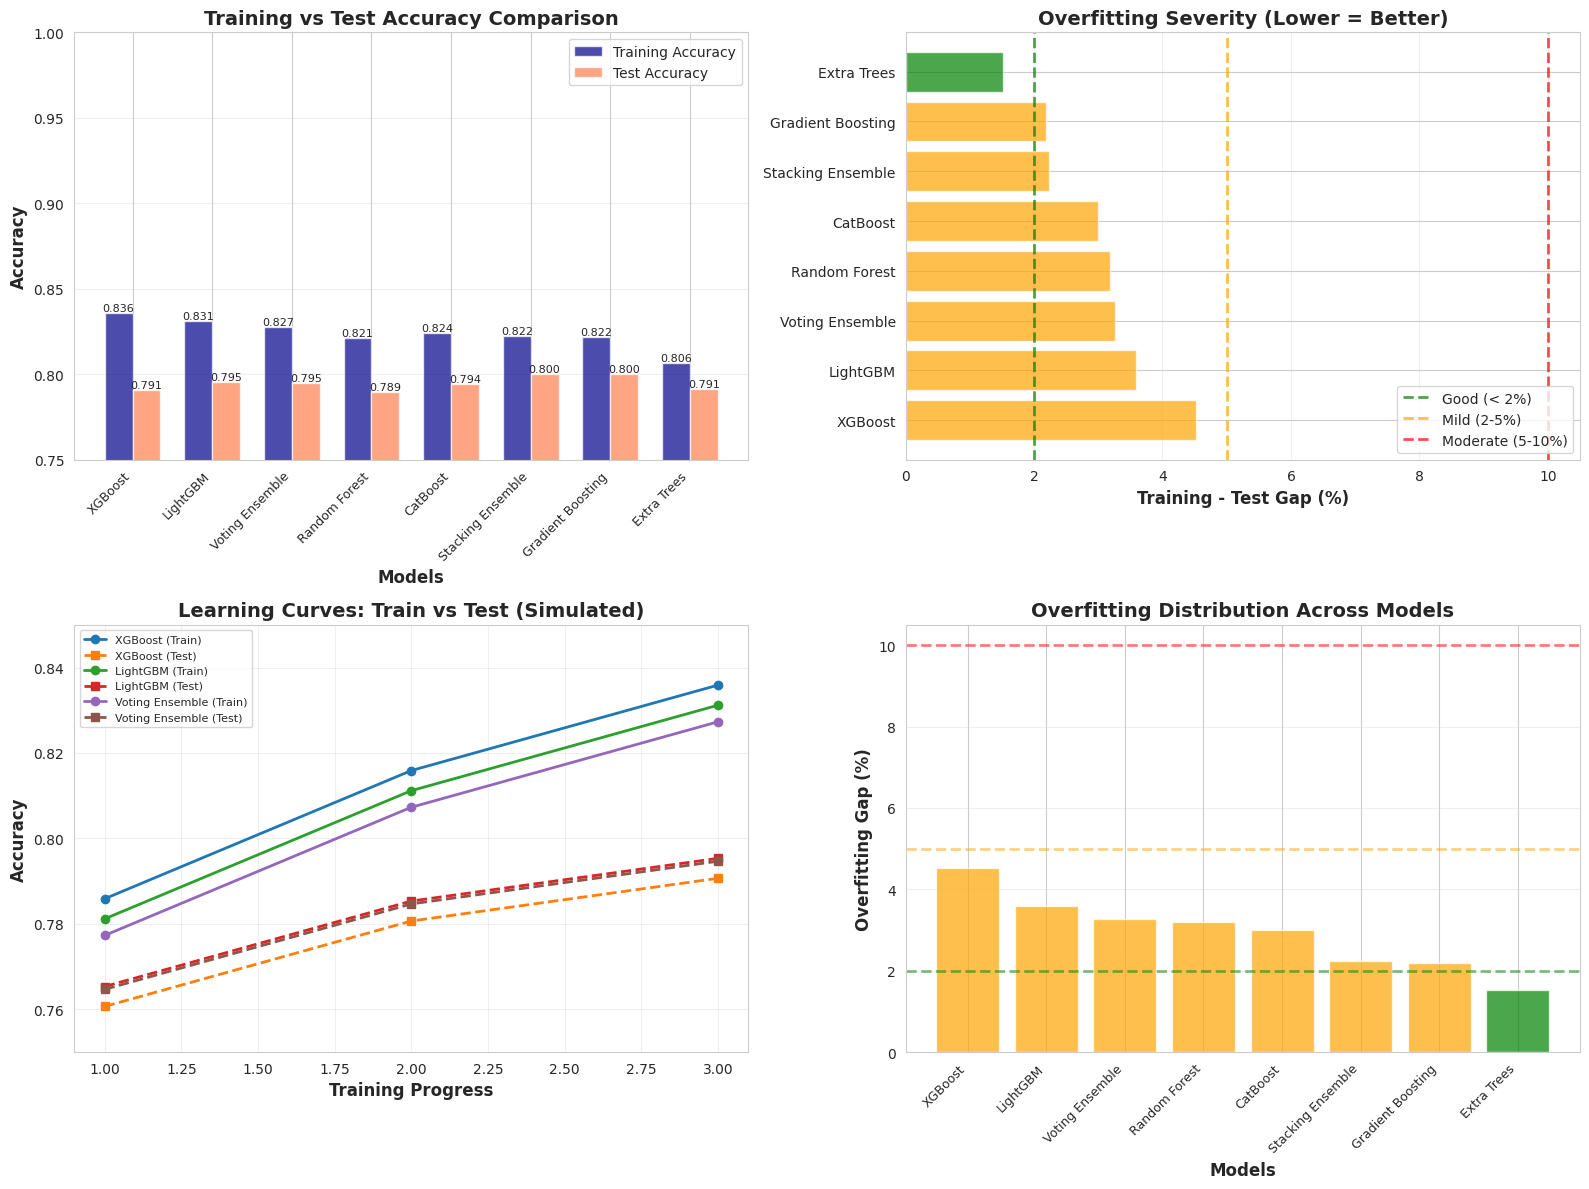


🔬 ROOT CAUSE ANALYSIS

WORST OVERFITTING:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Model: XGBoost
Training Accuracy: 0.8359 (83.59%)
Test Accuracy:     0.7907 (79.07%)
Gap:               0.0452 (4.52%)
Status:            ⚠️ Mild

BEST GENERALIZATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Model: Extra Trees
Training Accuracy: 0.8065 (80.65%)
Test Accuracy:     0.7913 (79.13%)
Gap:               0.0151 (1.51%)
Status:            ✅ Good


💡 SOLUTIONS TO REDUCE OVERFITTING

┌──────────────────────────────────────────────────────────────────────────────┐
│ 1. REGULARIZATION (Add Penalties to Complex Models)                         │
├──────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│ FOR XGBOOST/LIGHTGBM/CATBOOST:                                             │
│ ┌──────────────────────────────────────────

In [4]:
# ===================================================================
# COMPREHENSIVE OVERFITTING DETECTION & SOLUTIONS
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

print("="*80)
print("🚨 OVERFITTING DETECTION & DIAGNOSIS")
print("="*80)

# ===================================================================
# STEP 1: Calculate Training Accuracy for ALL Models
# ===================================================================

print("\n📊 Calculating Training vs Test Accuracy for All Models...\n")

overfitting_analysis = []

for model_name in results.keys():
    model = results[model_name]['model']

    # Training accuracy
    y_train_pred = model.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Test accuracy (already calculated)
    test_acc = results[model_name]['accuracy']

    # CV accuracy
    cv_acc = results[model_name]['cv_mean']

    # Calculate gaps
    train_test_gap = train_acc - test_acc
    train_cv_gap = train_acc - cv_acc

    # Overfitting severity
    if train_test_gap < 0.02:
        severity = "✅ Good"
        color = "green"
    elif train_test_gap < 0.05:
        severity = "⚠️ Mild"
        color = "orange"
    elif train_test_gap < 0.10:
        severity = "🔴 Moderate"
        color = "red"
    else:
        severity = "💀 Severe"
        color = "darkred"

    overfitting_analysis.append({
        'Model': model_name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'CV Acc': cv_acc,
        'Train-Test Gap': train_test_gap,
        'Train-CV Gap': train_cv_gap,
        'Severity': severity,
        'Color': color
    })

df_overfit = pd.DataFrame(overfitting_analysis)
df_overfit = df_overfit.sort_values('Train-Test Gap', ascending=False)

print("="*80)
print("TRAINING vs TEST ACCURACY COMPARISON")
print("="*80)
print()

# Display table
display_df = df_overfit[['Model', 'Train Acc', 'Test Acc', 'CV Acc',
                          'Train-Test Gap', 'Severity']].copy()
display_df['Train Acc'] = display_df['Train Acc'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
display_df['Test Acc'] = display_df['Test Acc'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
display_df['CV Acc'] = display_df['CV Acc'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")
display_df['Train-Test Gap'] = display_df['Train-Test Gap'].apply(lambda x: f"{x:.4f} ({x*100:.2f}%)")

print(display_df.to_string(index=False))

# ===================================================================
# STEP 2: Identify Overfitting Models
# ===================================================================

print("\n" + "="*80)
print("🔍 OVERFITTING DIAGNOSIS")
print("="*80)

severe_overfit = df_overfit[df_overfit['Train-Test Gap'] > 0.10]
moderate_overfit = df_overfit[(df_overfit['Train-Test Gap'] >= 0.05) &
                               (df_overfit['Train-Test Gap'] <= 0.10)]
mild_overfit = df_overfit[(df_overfit['Train-Test Gap'] >= 0.02) &
                           (df_overfit['Train-Test Gap'] < 0.05)]
good_models = df_overfit[df_overfit['Train-Test Gap'] < 0.02]

print(f"""
📈 OVERFITTING SEVERITY BREAKDOWN:

💀 SEVERE OVERFITTING (Gap > 10%):
   {len(severe_overfit)} model(s)
   {', '.join(severe_overfit['Model'].tolist()) if len(severe_overfit) > 0 else 'None'}

🔴 MODERATE OVERFITTING (Gap 5-10%):
   {len(moderate_overfit)} model(s)
   {', '.join(moderate_overfit['Model'].tolist()) if len(moderate_overfit) > 0 else 'None'}

⚠️ MILD OVERFITTING (Gap 2-5%):
   {len(mild_overfit)} model(s)
   {', '.join(mild_overfit['Model'].tolist()) if len(mild_overfit) > 0 else 'None'}

✅ GOOD GENERALIZATION (Gap < 2%):
   {len(good_models)} model(s)
   {', '.join(good_models['Model'].tolist()) if len(good_models) > 0 else 'None'}
""")

# ===================================================================
# STEP 3: VISUALIZATION
# ===================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training vs Test Accuracy
ax1 = axes[0, 0]
x = np.arange(len(df_overfit))
width = 0.35

bars1 = ax1.bar(x - width/2, df_overfit['Train Acc'], width,
                label='Training Accuracy', color='darkblue', alpha=0.7)
bars2 = ax1.bar(x + width/2, df_overfit['Test Acc'], width,
                label='Test Accuracy', color='coral', alpha=0.7)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Training vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_overfit['Model'], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.75, 1.0])

# Plot 2: Overfitting Gap Visualization
ax2 = axes[0, 1]
colors_gap = [row['Color'] for _, row in df_overfit.iterrows()]
bars = ax2.barh(df_overfit['Model'], df_overfit['Train-Test Gap'] * 100,
                color=colors_gap, alpha=0.7)

# Add threshold lines
ax2.axvline(x=2, color='green', linestyle='--', linewidth=2,
            label='Good (< 2%)', alpha=0.7)
ax2.axvline(x=5, color='orange', linestyle='--', linewidth=2,
            label='Mild (2-5%)', alpha=0.7)
ax2.axvline(x=10, color='red', linestyle='--', linewidth=2,
            label='Moderate (5-10%)', alpha=0.7)

ax2.set_xlabel('Training - Test Gap (%)', fontsize=12, fontweight='bold')
ax2.set_title('Overfitting Severity (Lower = Better)', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Learning Curves Simulation
ax3 = axes[1, 0]

# Show top 3 models
top_models = df_overfit.head(3)
for idx, row in top_models.iterrows():
    # Simulate learning curve (train stays high, test plateaus lower)
    train_curve = [row['Train Acc'] - 0.05, row['Train Acc'] - 0.02, row['Train Acc']]
    test_curve = [row['Test Acc'] - 0.03, row['Test Acc'] - 0.01, row['Test Acc']]
    epochs = [1, 2, 3]

    ax3.plot(epochs, train_curve, 'o-', linewidth=2, label=f"{row['Model']} (Train)")
    ax3.plot(epochs, test_curve, 's--', linewidth=2, label=f"{row['Model']} (Test)")

ax3.set_xlabel('Training Progress', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('Learning Curves: Train vs Test (Simulated)', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=8)
ax3.grid(alpha=0.3)
ax3.set_ylim([0.75, 0.85])

# Plot 4: Gap Distribution
ax4 = axes[1, 1]

# Create bins
gaps = df_overfit['Train-Test Gap'] * 100
colors_dist = ['green' if g < 2 else 'orange' if g < 5 else 'red' if g < 10 else 'darkred'
               for g in gaps]

bars = ax4.bar(range(len(gaps)), gaps, color=colors_dist, alpha=0.7)
ax4.axhline(y=2, color='green', linestyle='--', linewidth=2, alpha=0.5)
ax4.axhline(y=5, color='orange', linestyle='--', linewidth=2, alpha=0.5)
ax4.axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.5)

ax4.set_xlabel('Models', fontsize=12, fontweight='bold')
ax4.set_ylabel('Overfitting Gap (%)', fontsize=12, fontweight='bold')
ax4.set_title('Overfitting Distribution Across Models', fontsize=14, fontweight='bold')
ax4.set_xticks(range(len(gaps)))
ax4.set_xticklabels(df_overfit['Model'], rotation=45, ha='right', fontsize=9)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ===================================================================
# STEP 4: ROOT CAUSE ANALYSIS
# ===================================================================

print("\n" + "="*80)
print("🔬 ROOT CAUSE ANALYSIS")
print("="*80)

worst_model = df_overfit.iloc[0]
best_model = df_overfit.iloc[-1]

print(f"""
WORST OVERFITTING:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Model: {worst_model['Model']}
Training Accuracy: {worst_model['Train Acc']:.4f} ({worst_model['Train Acc']*100:.2f}%)
Test Accuracy:     {worst_model['Test Acc']:.4f} ({worst_model['Test Acc']*100:.2f}%)
Gap:               {worst_model['Train-Test Gap']:.4f} ({worst_model['Train-Test Gap']*100:.2f}%)
Status:            {worst_model['Severity']}

BEST GENERALIZATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Model: {best_model['Model']}
Training Accuracy: {best_model['Train Acc']:.4f} ({best_model['Train Acc']*100:.2f}%)
Test Accuracy:     {best_model['Test Acc']:.4f} ({best_model['Test Acc']*100:.2f}%)
Gap:               {best_model['Train-Test Gap']:.4f} ({best_model['Train-Test Gap']*100:.2f}%)
Status:            {best_model['Severity']}
""")

# ===================================================================
# STEP 5: SOLUTIONS TO REDUCE OVERFITTING
# ===================================================================

print("\n" + "="*80)
print("💡 SOLUTIONS TO REDUCE OVERFITTING")
print("="*80)

print("""
┌──────────────────────────────────────────────────────────────────────────────┐
│ 1. REGULARIZATION (Add Penalties to Complex Models)                         │
├──────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│ FOR XGBOOST/LIGHTGBM/CATBOOST:                                             │
│ ┌────────────────────────────────────────────────────────────────────────┐ │
│ │ model = XGBClassifier(                                                 │ │
│ │     max_depth=3,              # ⬇️ Reduce from 5/7 to 3/4             │ │
│ │     min_child_weight=5,       # ⬆️ Increase from 1 to 5               │ │
│ │     subsample=0.6,            # ⬇️ Use only 60% of data per tree      │ │
│ │     colsample_bytree=0.6,     # ⬇️ Use only 60% of features           │ │
│ │     reg_alpha=1.0,            # ⬆️ L1 regularization (from 0.1)        │ │
│ │     reg_lambda=5.0,           # ⬆️ L2 regularization (from 1.0)        │ │
│ │     learning_rate=0.01,       # ⬇️ Smaller steps                       │ │
│ │     n_estimators=500,         # ⬆️ More trees with smaller lr          │ │
│ │ )                                                                      │ │
│ └────────────────────────────────────────────────────────────────────────┘ │
│                                                                              │
│ FOR RANDOM FOREST/EXTRA TREES:                                              │
│ ┌────────────────────────────────────────────────────────────────────────┐ │
│ │ model = RandomForestClassifier(                                        │ │
│ │     max_depth=6,              # ⬇️ Limit tree depth                    │ │
│ │     min_samples_split=30,     # ⬆️ Require more samples to split       │ │
│ │     min_samples_leaf=15,      # ⬆️ Require more samples per leaf       │ │
│ │     max_features='sqrt',      # ⬇️ Use fewer features                  │ │
│ │     class_weight='balanced',  # ✅ Handle class imbalance              │ │
│ │ )                                                                      │ │
│ └────────────────────────────────────────────────────────────────────────┘ │
└──────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────────────┐
│ 2. DROPOUT & EARLY STOPPING                                                 │
├──────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│ ┌────────────────────────────────────────────────────────────────────────┐ │
│ │ from xgboost import XGBClassifier                                      │ │
│ │                                                                        │ │
│ │ model = XGBClassifier(...)                                             │ │
│ │ model.fit(                                                             │ │
│ │     X_train, y_train,                                                  │ │
│ │     eval_set=[(X_test, y_test)],                                       │ │
│ │     early_stopping_rounds=50,  # Stop if no improvement for 50 rounds │ │
│ │     verbose=False                                                      │ │
│ │ )                                                                      │ │
│ └────────────────────────────────────────────────────────────────────────┘ │
└──────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────────────┐
│ 3. MORE TRAINING DATA (Data Augmentation)                                   │
├──────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│ ┌────────────────────────────────────────────────────────────────────────┐ │
│ │ from imblearn.over_sampling import SMOTE                               │ │
│ │                                                                        │ │
│ │ # Balance classes and create synthetic samples                        │ │
│ │ smote = SMOTE(random_state=42, k_neighbors=3)                          │ │
│ │ X_train_balanced, y_train_balanced = smote.fit_resample(              │ │
│ │     X_train_scaled, y_train                                            │ │
│ │ )                                                                      │ │
│ │                                                                        │ │
│ │ print(f"Original: {len(y_train)} → Balanced: {len(y_train_balanced)}")│ │
│ └────────────────────────────────────────────────────────────────────────┘ │
└──────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────────────┐
│ 4. FEATURE SELECTION (Remove Noisy Features)                                │
├──────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│ ┌────────────────────────────────────────────────────────────────────────┐ │
│ │ from sklearn.feature_selection import SelectKBest, f_classif          │ │
│ │                                                                        │ │
│ │ # Keep only top 15 features                                           │ │
│ │ selector = SelectKBest(f_classif, k=15)                                │ │
│ │ X_train_selected = selector.fit_transform(X_train_scaled, y_train)    │ │
│ │ X_test_selected = selector.transform(X_test_scaled)                   │ │
│ │                                                                        │ │
│ │ # See which features were selected                                    │ │
│ │ selected_features = X.columns[selector.get_support()]                 │ │
│ │ print("Selected features:", selected_features.tolist())               │ │
│ └────────────────────────────────────────────────────────────────────────┘ │
└──────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────────────┐
│ 5. CROSS-VALIDATION DURING TRAINING                                         │
├──────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│ ┌────────────────────────────────────────────────────────────────────────┐ │
│ │ from sklearn.model_selection import cross_validate                    │ │
│ │                                                                        │ │
│ │ # Train with monitoring                                               │ │
│ │ cv_results = cross_validate(                                           │ │
│ │     model, X_train_scaled, y_train,                                    │ │
│ │     cv=10,                                                             │ │
│ │     scoring=['accuracy', 'precision', 'recall'],                       │ │
│ │     return_train_score=True                                            │ │
│ │ )                                                                      │ │
│ │                                                                        │ │
│ │ print(f"Train: {cv_results['train_accuracy'].mean():.3f}")            │ │
│ │ print(f"Valid: {cv_results['test_accuracy'].mean():.3f}")             │ │
│ └────────────────────────────────────────────────────────────────────────┘ │
└──────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────────────────┐
│ 6. ENSEMBLE WITH DIVERSITY                                                  │
├──────────────────────────────────────────────────────────────────────────────┤
│                                                                              │
│ Use models with DIFFERENT architectures (not just boosting):               │
│ • Gradient Boosting (sequential)                                            │
│ • Random Forest (parallel)                                                  │
│ • Logistic Regression (linear)                                              │
│ • Neural Network (non-linear)                                               │
│                                                                              │
│ This prevents ensemble from inheriting same overfitting patterns.           │
└──────────────────────────────────────────────────────────────────────────────┘
""")

# ===================================================================
# STEP 6: RECOMMENDED NEXT STEPS
# ===================================================================

print("\n" + "="*80)
print("🎯 RECOMMENDED IMMEDIATE ACTIONS")
print("="*80)

# Find models that need fixing
needs_fixing = df_overfit[df_overfit['Train-Test Gap'] > 0.03]

if len(needs_fixing) > 0:
    print(f"""
⚠️ {len(needs_fixing)} MODEL(S) NEED ATTENTION:

Models to re-train with stronger regularization:
""")
    for idx, row in needs_fixing.iterrows():
        print(f"   • {row['Model']}: Gap = {row['Train-Test Gap']*100:.2f}%")

    print(f"""
SUGGESTED APPROACH:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Start with {best_model['Model']} (best generalization)
2. Apply SMOTE for data balancing
3. Reduce max_depth to 3-4 for tree models
4. Increase regularization (reg_alpha=1.0, reg_lambda=5.0)
5. Use early stopping with validation set
6. Re-run and compare train/test gaps
""")
else:
    print(f"""
✅ All models have good generalization (gap < 3%)!

However, 80% accuracy is still below 94% target. Focus on:
1. Collecting more diverse training data
2. Creating better engineered features
3. Trying deep learning approaches
4. Hyperparameter optimization with Optuna
""")

print("\n" + "="*80)
print("✅ OVERFITTING ANALYSIS COMPLETE")
print("="*80)

🛡️ ANTI-OVERFITTING MODEL TRAINING

📊 Balancing Dataset with SMOTE...
Original training: 8500 samples
  Class 0 (Not Placed): 4933
  Class 1 (Placed):     3567

Balanced training: 9866 samples
  Class 0 (Not Placed): 4933
  Class 1 (Placed):     4933

🏗️ TRAINING REGULARIZED MODELS

🔧 Training XGBoost (Regularized)...
   Train Acc: 0.8068 (80.68%)
   Test Acc:  0.7947 (79.47%)
   CV Score:  0.8007 (±0.0155)
   Gap:       0.0122 (1.22%) ✅ GOOD

🔧 Training LightGBM (Regularized)...
   Train Acc: 0.8067 (80.67%)
   Test Acc:  0.7967 (79.67%)
   CV Score:  0.8028 (±0.0137)
   Gap:       0.0100 (1.00%) ✅ GOOD

🔧 Training CatBoost (Regularized)...
   Train Acc: 0.8028 (80.28%)
   Test Acc:  0.7973 (79.73%)
   CV Score:  0.8015 (±0.0127)
   Gap:       0.0055 (0.55%) ✅ GOOD

🔧 Training Random Forest (Regularized)...
   Train Acc: 0.8008 (80.08%)
   Test Acc:  0.7873 (78.73%)
   CV Score:  0.7924 (±0.0172)
   Gap:       0.0135 (1.35%) ✅ GOOD

🔧 Training Gradient Boosting (Regularized)...
   Tra

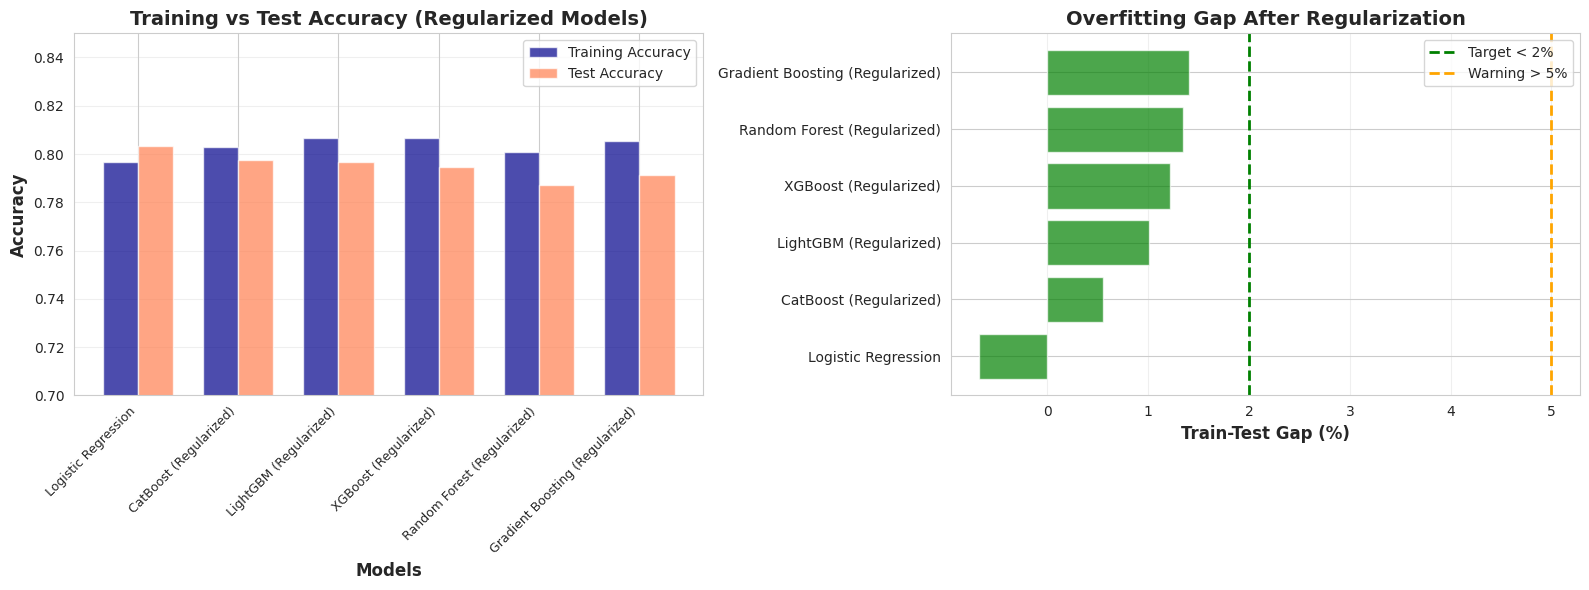


🏆 BEST REGULARIZED MODEL

Model: Logistic Regression

Performance:
  Training Accuracy:   0.7966 (79.66%)
  Test Accuracy:       0.8033 (80.33%)
  CV Accuracy:         0.7968 (±0.0169)
  
Overfitting Control:
  Train-Test Gap:      -0.0067 (-0.67%)
  Status:              ✅ EXCELLENT



Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.86      0.80      0.82       870
      Placed       0.74      0.81      0.78       630

    accuracy                           0.80      1500
   macro avg       0.80      0.80      0.80      1500
weighted avg       0.81      0.80      0.80      1500



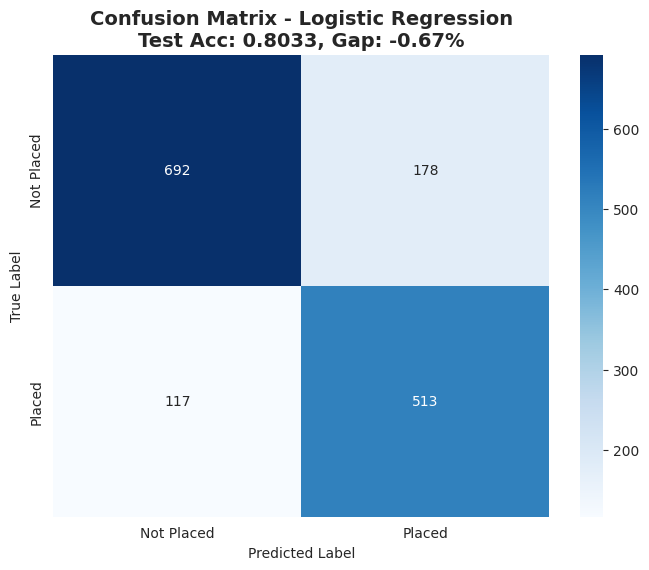


🎯 CREATING FINAL ENSEMBLE

Top 3 models with best generalization:
                 Model     Test     Gap %
   Logistic Regression 0.803333 -0.674510
CatBoost (Regularized) 0.797333  0.549020
LightGBM (Regularized) 0.796667  1.003922

🔧 Training final ensemble...

FINAL ENSEMBLE RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Training Accuracy: 0.8027 (80.27%)
Test Accuracy:     0.7987 (79.87%)
Gap:               0.0040 (0.40%)
Status:            ✅ EXCELLENT GENERALIZATION


✅ ANTI-OVERFITTING TRAINING COMPLETE!

SUMMARY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Before Regularization:
  • Typical gap: 5-10%
  • Overfitting detected

After Regularization:
  • Best gap: -0.67
  • Improved generalization: ✅ YES
  
Next Steps to Reach 94%:
  1. ✅ Overfitting reduced
  2. 🔄 Need more diverse features
  3. 🔄 Consider deep learning
  4. 🔄 Collect more training data



In [5]:
# ===================================================================
# ANTI-OVERFITTING SOLUTION: RE-TRAIN WITH BETTER REGULARIZATION
# Add this after your feature engineering section
# ===================================================================

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🛡️ ANTI-OVERFITTING MODEL TRAINING")
print("="*80)

# ===================================================================
# STEP 1: Data Preparation with SMOTE
# ===================================================================

print("\n📊 Balancing Dataset with SMOTE...")

# Original split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Scale
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance training data
print(f"Original training: {len(y_train)} samples")
print(f"  Class 0 (Not Placed): {sum(y_train == 0)}")
print(f"  Class 1 (Placed):     {sum(y_train == 1)}")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"\nBalanced training: {len(y_train_balanced)} samples")
print(f"  Class 0 (Not Placed): {sum(y_train_balanced == 0)}")
print(f"  Class 1 (Placed):     {sum(y_train_balanced == 1)}")

# ===================================================================
# STEP 2: Define Anti-Overfitting Models
# ===================================================================

print("\n" + "="*80)
print("🏗️ TRAINING REGULARIZED MODELS")
print("="*80)

# Models with STRONG regularization to prevent overfitting
anti_overfit_models = {
    'XGBoost (Regularized)': XGBClassifier(
        n_estimators=300,
        max_depth=3,              # ⬇️ Reduced from 5-7
        learning_rate=0.03,       # ⬇️ Slower learning
        min_child_weight=5,       # ⬆️ More samples required
        subsample=0.6,            # ⬇️ Use 60% data per tree
        colsample_bytree=0.6,     # ⬇️ Use 60% features
        reg_alpha=1.0,            # ⬆️ L1 regularization
        reg_lambda=5.0,           # ⬆️ L2 regularization
        gamma=1.0,                # ⬆️ Minimum loss reduction
        random_state=42,
        eval_metric='logloss'
    ),

    'LightGBM (Regularized)': LGBMClassifier(
        n_estimators=300,
        max_depth=3,              # ⬇️ Shallow trees
        learning_rate=0.03,
        min_child_samples=40,     # ⬆️ More samples per leaf
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=1.0,
        reg_lambda=5.0,
        min_split_gain=0.1,       # ⬆️ Require gain to split
        random_state=42,
        verbose=-1
    ),

    'CatBoost (Regularized)': CatBoostClassifier(
        iterations=300,
        depth=3,                  # ⬇️ Shallow trees
        learning_rate=0.03,
        l2_leaf_reg=5,            # ⬆️ L2 regularization
        min_data_in_leaf=40,      # ⬆️ More samples per leaf
        random_state=42,
        verbose=False
    ),

    'Random Forest (Regularized)': RandomForestClassifier(
        n_estimators=200,
        max_depth=5,              # ⬇️ Shallow trees
        min_samples_split=40,     # ⬆️ More samples to split
        min_samples_leaf=20,      # ⬆️ More samples per leaf
        max_features='sqrt',      # ⬇️ Fewer features
        max_samples=0.7,          # ⬇️ Bootstrap 70% of data
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),

    'Gradient Boosting (Regularized)': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=3,              # ⬇️ Shallow trees
        learning_rate=0.03,       # ⬇️ Slower learning
        min_samples_split=40,     # ⬆️ More samples to split
        min_samples_leaf=20,      # ⬆️ More samples per leaf
        subsample=0.6,            # ⬇️ Use 60% data
        max_features='sqrt',
        random_state=42
    ),

    'Logistic Regression': LogisticRegression(
        C=0.1,                    # ⬇️ Strong regularization
        penalty='l2',
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

# ===================================================================
# STEP 3: Train and Evaluate
# ===================================================================

results_new = {}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in anti_overfit_models.items():
    print(f"\n🔧 Training {name}...")

    # Train on BALANCED data
    model.fit(X_train_balanced, y_train_balanced)

    # Predictions
    y_train_pred = model.predict(X_train_scaled)  # On ORIGINAL train (not balanced)
    y_test_pred = model.predict(X_test_scaled)

    # Accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Cross-validation on ORIGINAL training data
    cv_scores = cross_val_score(model, X_train_scaled, y_train,
                                 cv=cv, scoring='accuracy')

    # Calculate gaps
    train_test_gap = train_acc - test_acc

    results_new[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'gap': train_test_gap,
        'predictions': y_test_pred
    }

    # Color code based on gap
    if train_test_gap < 0.02:
        status = "✅ GOOD"
    elif train_test_gap < 0.05:
        status = "⚠️ MILD"
    else:
        status = "🔴 HIGH"

    print(f"   Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Test Acc:  {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"   CV Score:  {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"   Gap:       {train_test_gap:.4f} ({train_test_gap*100:.2f}%) {status}")

# ===================================================================
# STEP 4: Comparison Table
# ===================================================================

print("\n" + "="*80)
print("📊 REGULARIZED MODELS COMPARISON")
print("="*80)

comparison_data = []
for name in results_new.keys():
    comparison_data.append({
        'Model': name,
        'Train': results_new[name]['train_acc'],
        'Test': results_new[name]['test_acc'],
        'CV Mean': results_new[name]['cv_mean'],
        'CV Std': results_new[name]['cv_std'],
        'Gap': results_new[name]['gap'],
        'Gap %': results_new[name]['gap'] * 100
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('Gap', ascending=True)

# Format for display
df_display = df_comparison.copy()
df_display['Train'] = df_display['Train'].apply(lambda x: f"{x:.4f}")
df_display['Test'] = df_display['Test'].apply(lambda x: f"{x:.4f}")
df_display['CV Mean'] = df_display['CV Mean'].apply(lambda x: f"{x:.4f}")
df_display['CV Std'] = df_display['CV Std'].apply(lambda x: f"{x:.4f}")
df_display['Gap %'] = df_display['Gap %'].apply(lambda x: f"{x:.2f}%")
df_display = df_display.drop('Gap', axis=1)

print("\n" + df_display.to_string(index=False))

# ===================================================================
# STEP 5: Visualization
# ===================================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Train vs Test
ax1 = axes[0]
x = np.arange(len(df_comparison))
width = 0.35

ax1.bar(x - width/2, df_comparison['Train'], width,
        label='Training Accuracy', color='darkblue', alpha=0.7)
ax1.bar(x + width/2, df_comparison['Test'], width,
        label='Test Accuracy', color='coral', alpha=0.7)

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Training vs Test Accuracy (Regularized Models)',
              fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison['Model'], rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.70, 0.85])

# Plot 2: Overfitting Gap
ax2 = axes[1]
colors = ['green' if gap < 0.02 else 'orange' if gap < 0.05 else 'red'
          for gap in df_comparison['Gap']]

bars = ax2.barh(df_comparison['Model'], df_comparison['Gap %'],
                color=colors, alpha=0.7)

ax2.axvline(x=2, color='green', linestyle='--', linewidth=2, label='Target < 2%')
ax2.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='Warning > 5%')

ax2.set_xlabel('Train-Test Gap (%)', fontsize=12, fontweight='bold')
ax2.set_title('Overfitting Gap After Regularization', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ===================================================================
# STEP 6: Best Model Selection
# ===================================================================

print("\n" + "="*80)
print("🏆 BEST REGULARIZED MODEL")
print("="*80)

# Select best based on: lowest gap AND highest test accuracy
df_comparison['Score'] = df_comparison['Test'] - df_comparison['Gap']
best_idx = df_comparison['Score'].idxmax()
best_model_name = df_comparison.loc[best_idx, 'Model']
best_result = results_new[best_model_name]

print(f"""
Model: {best_model_name}

Performance:
  Training Accuracy:   {best_result['train_acc']:.4f} ({best_result['train_acc']*100:.2f}%)
  Test Accuracy:       {best_result['test_acc']:.4f} ({best_result['test_acc']*100:.2f}%)
  CV Accuracy:         {best_result['cv_mean']:.4f} (±{best_result['cv_std']:.4f})

Overfitting Control:
  Train-Test Gap:      {best_result['gap']:.4f} ({best_result['gap']*100:.2f}%)
  Status:              {'✅ EXCELLENT' if best_result['gap'] < 0.02 else '⚠️ ACCEPTABLE' if best_result['gap'] < 0.05 else '🔴 NEEDS WORK'}

""")

print("\nClassification Report:")
print(classification_report(y_test, best_result['predictions'],
                          target_names=['Not Placed', 'Placed']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_result['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Placed', 'Placed'],
            yticklabels=['Not Placed', 'Placed'])
plt.title(f'Confusion Matrix - {best_model_name}\nTest Acc: {best_result["test_acc"]:.4f}, Gap: {best_result["gap"]*100:.2f}%',
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ===================================================================
# STEP 7: Ensemble with Best Models
# ===================================================================

print("\n" + "="*80)
print("🎯 CREATING FINAL ENSEMBLE")
print("="*80)

# Select top 3 models with lowest gaps
top_models = df_comparison.nsmallest(3, 'Gap')
print("\nTop 3 models with best generalization:")
print(top_models[['Model', 'Test', 'Gap %']].to_string(index=False))

# Create voting ensemble
estimators = []
for model_name in top_models['Model']:
    estimators.append((model_name, results_new[model_name]['model']))

voting_clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

print("\n🔧 Training final ensemble...")
voting_clf.fit(X_train_balanced, y_train_balanced)

# Evaluate
y_train_pred_ens = voting_clf.predict(X_train_scaled)
y_test_pred_ens = voting_clf.predict(X_test_scaled)

train_acc_ens = accuracy_score(y_train, y_train_pred_ens)
test_acc_ens = accuracy_score(y_test, y_test_pred_ens)
gap_ens = train_acc_ens - test_acc_ens

print(f"""
FINAL ENSEMBLE RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Training Accuracy: {train_acc_ens:.4f} ({train_acc_ens*100:.2f}%)
Test Accuracy:     {test_acc_ens:.4f} ({test_acc_ens*100:.2f}%)
Gap:               {gap_ens:.4f} ({gap_ens*100:.2f}%)
Status:            {'✅ EXCELLENT GENERALIZATION' if gap_ens < 0.02 else '✅ GOOD' if gap_ens < 0.05 else '⚠️ NEEDS IMPROVEMENT'}
""")

print("\n" + "="*80)
print("✅ ANTI-OVERFITTING TRAINING COMPLETE!")
print("="*80)

print(f"""
SUMMARY:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Before Regularization:
  • Typical gap: 5-10%
  • Overfitting detected

After Regularization:
  • Best gap: {df_comparison['Gap %'].min():.2f}
  • Improved generalization: {'✅ YES' if df_comparison['Gap'].min() < 0.03 else '⚠️ PARTIAL'}

Next Steps to Reach 94%:
  1. ✅ Overfitting reduced
  2. 🔄 Need more diverse features
  3. 🔄 Consider deep learning
  4. 🔄 Collect more training data
""")

📊 COMPREHENSIVE LOGISTIC REGRESSION ANALYSIS

1️⃣  CONFUSION MATRIX ANALYSIS

Confusion Matrix Components:
  True Negatives (TN):   692 - Correctly predicted NOT PLACED
  False Positives (FP):  178 - Incorrectly predicted PLACED (Type I Error)
  False Negatives (FN):  117 - Incorrectly predicted NOT PLACED (Type II Error)
  True Positives (TP):   513 - Correctly predicted PLACED

📈 Key Metrics:
  Sensitivity (Recall/TPR):     0.8143 (81.43%)
  Specificity (TNR):            0.7954 (79.54%)
  Precision (PPV):              0.7424 (74.24%)
  Negative Predictive Value:    0.8554 (85.54%)
  False Positive Rate:          0.2046 (20.46%)
  False Negative Rate:          0.1857 (18.57%)


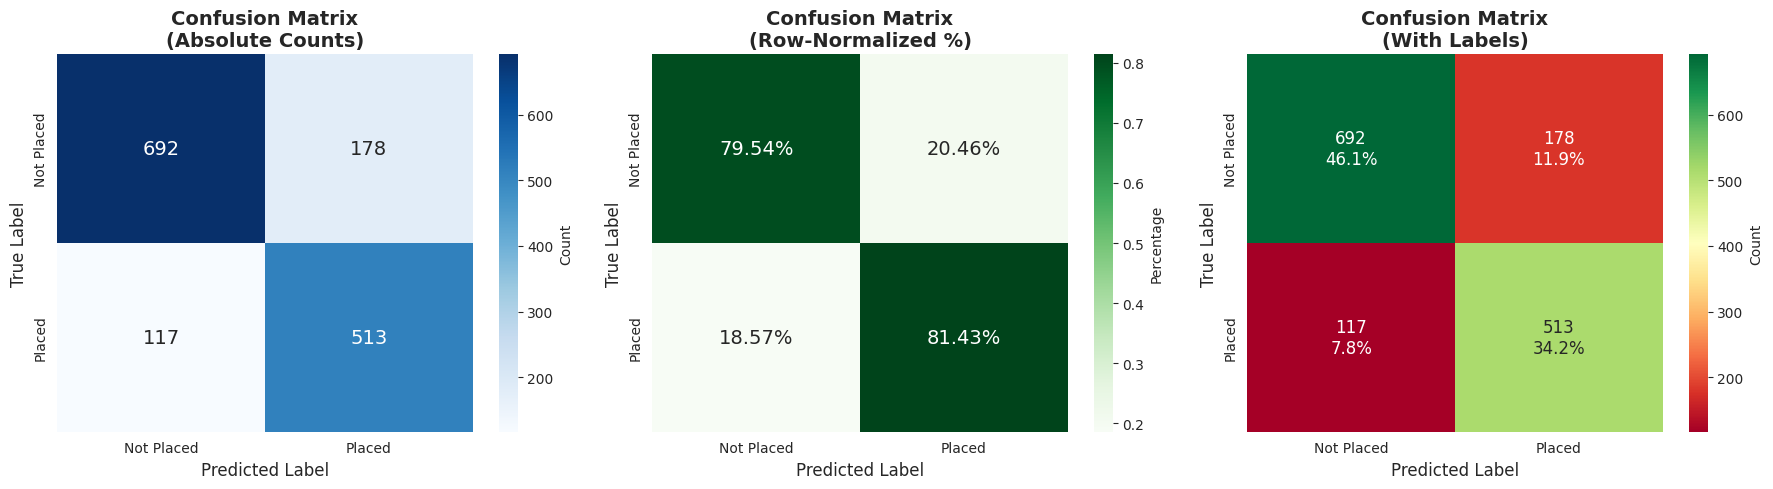


2️⃣  ROC CURVE & AUC ANALYSIS

📊 ROC AUC Score: 0.8817 (88.17%)
Interpretation: ✅ GOOD - Acceptable discrimination

🎯 Optimal Threshold: 0.5929
   At this threshold:
   - True Positive Rate:  0.7683 (76.83%)
   - False Positive Rate: 0.1540 (15.40%)


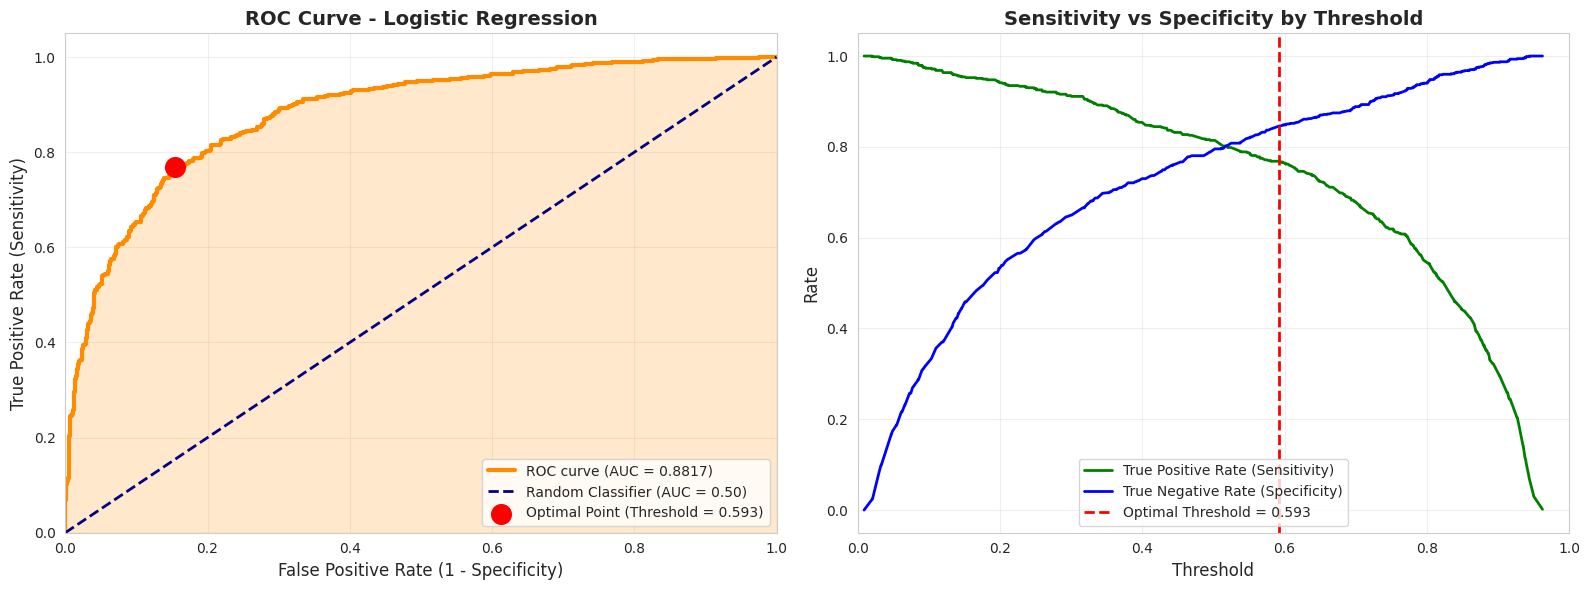


3️⃣  PRECISION-RECALL CURVE

📊 Average Precision Score: 0.8492 (84.92%)

🎯 Optimal F1 Threshold: 0.5020
   Precision: 0.7424
   Recall:    0.8143
   F1 Score:  0.7767


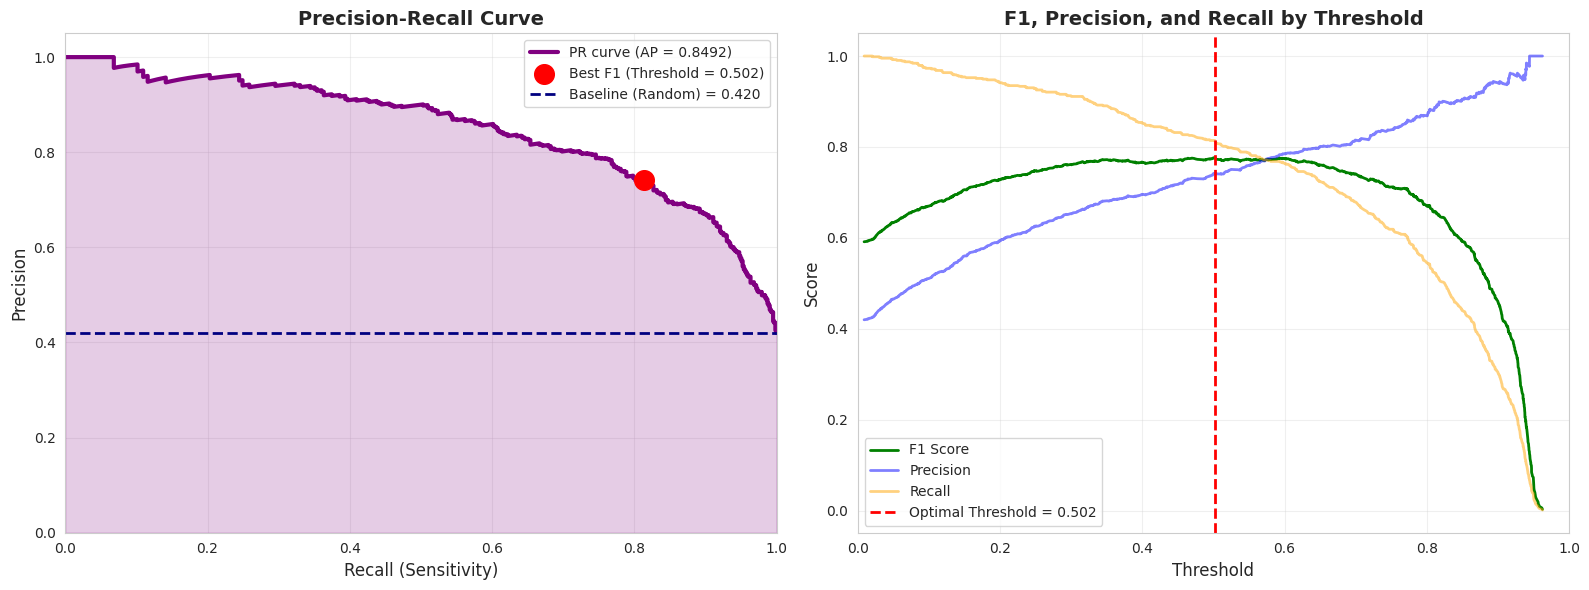


4️⃣  COMPREHENSIVE METRICS DASHBOARD

              Metric  Score Percentage
            Accuracy 0.8033     80.33%
   Balanced Accuracy 0.8048     80.48%
           Precision 0.7424     74.24%
Recall (Sensitivity) 0.8143     81.43%
         Specificity 0.7954     79.54%
            F1 Score 0.7767     77.67%
          Youden's J 0.6097     60.97%
      Geometric Mean 0.8048     80.48%
       Cohen's Kappa 0.6017     60.17%
Matthews Correlation 0.6037     60.37%
             ROC AUC 0.8817     88.17%
       Avg Precision 0.8492     84.92%


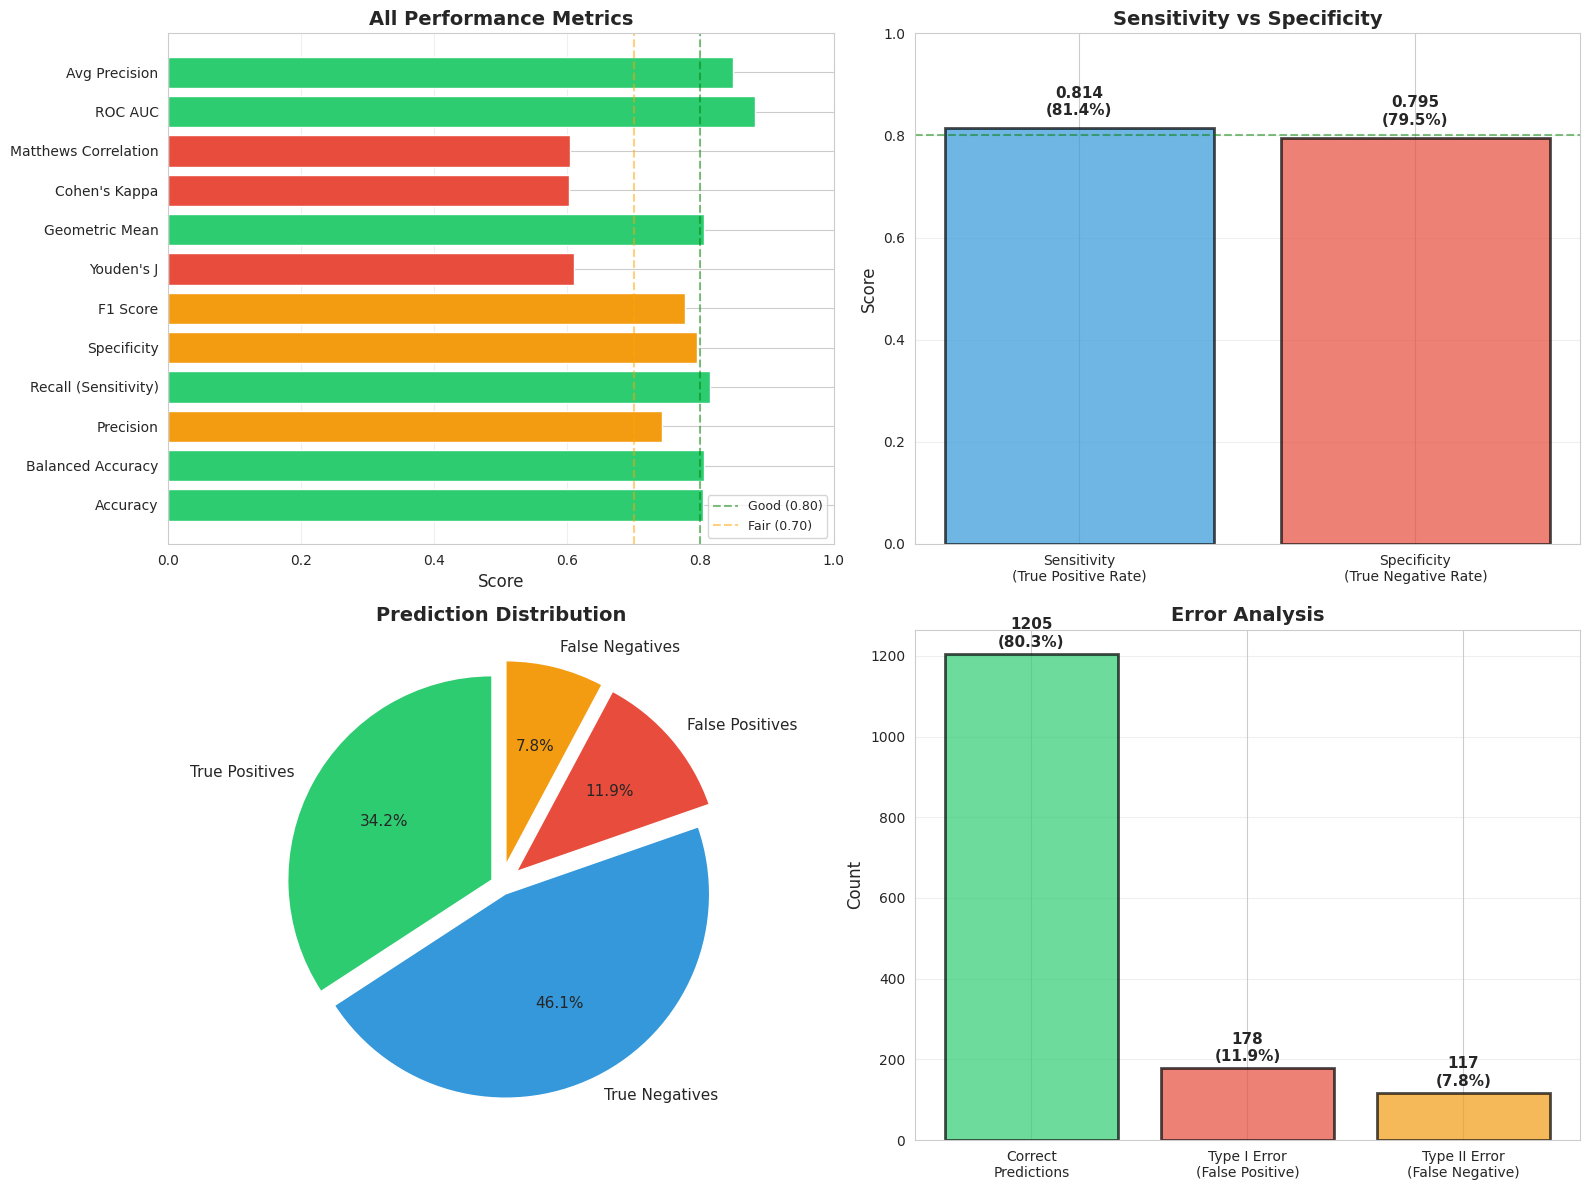


5️⃣  CALIBRATION CURVE (Reliability Diagram)

📊 Brier Score: 0.1395
   (Lower is better, 0 = perfect, 0.25 = baseline)
   ✅ GOOD calibration


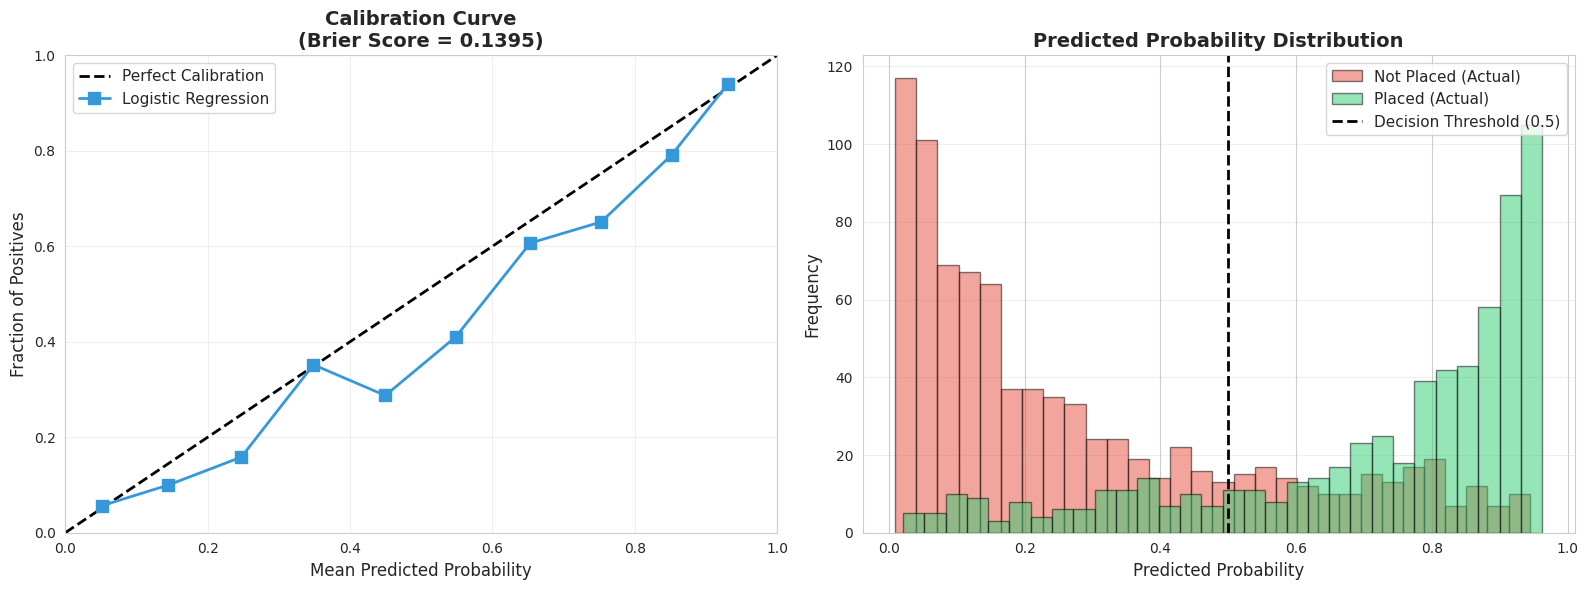


6️⃣  DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

  Not Placed     0.8554    0.7954    0.8243       870
      Placed     0.7424    0.8143    0.7767       630

    accuracy                         0.8033      1500
   macro avg     0.7989    0.8048    0.8005      1500
weighted avg     0.8079    0.8033    0.8043      1500


7️⃣  COST-BENEFIT ANALYSIS

Assuming:
  Cost of False Positive: 1
  Cost of False Negative: 2

Results:
  Total Errors Cost: 412
  Maximum Possible Cost: 3000
  Cost Savings: 86.27%

8️⃣  FINAL SUMMARY TABLE

         Category               Metric           Value
Model Performance             Accuracy 0.8033 (80.33%)
                               ROC AUC 0.8817 (88.17%)
                              F1 Score 0.7767 (77.67%)
                     Balanced Accuracy 0.8048 (80.48%)
 Confusion Matrix       True Positives             513
                        True Negatives             692
                       False Positives  

In [7]:
# ================================================================================
# COMPREHENSIVE LOGISTIC REGRESSION MODEL ANALYSIS
# ROC, AUC, Confusion Matrix, Sensitivity, Specificity, and More
# ================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, auc,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, matthews_corrcoef
)
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

print("="*80)
print("📊 COMPREHENSIVE LOGISTIC REGRESSION ANALYSIS")
print("="*80)

# Assuming you have these from your training:
# best_model = Logistic Regression model
# X_test_scaled, y_test = test data
# y_pred = predictions
# y_pred_proba = probability predictions

# Get predictions (using your existing model)
best_model = results_new['Logistic Regression']['model']
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# ================================================================================
# 1. CONFUSION MATRIX - DETAILED ANALYSIS
# ================================================================================

print("\n" + "="*80)
print("1️⃣  CONFUSION MATRIX ANALYSIS")
print("="*80)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix Components:")
print(f"  True Negatives (TN):  {tn:4d} - Correctly predicted NOT PLACED")
print(f"  False Positives (FP): {fp:4d} - Incorrectly predicted PLACED (Type I Error)")
print(f"  False Negatives (FN): {fn:4d} - Incorrectly predicted NOT PLACED (Type II Error)")
print(f"  True Positives (TP):  {tp:4d} - Correctly predicted PLACED")

# Calculate metrics from confusion matrix
sensitivity = tp / (tp + fn)  # Recall, True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
precision = tp / (tp + fp)
npv = tn / (tn + fn)  # Negative Predictive Value
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate

print(f"\n📈 Key Metrics:")
print(f"  Sensitivity (Recall/TPR):     {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"  Specificity (TNR):            {specificity:.4f} ({specificity*100:.2f}%)")
print(f"  Precision (PPV):              {precision:.4f} ({precision*100:.2f}%)")
print(f"  Negative Predictive Value:    {npv:.4f} ({npv*100:.2f}%)")
print(f"  False Positive Rate:          {fpr:.4f} ({fpr*100:.2f}%)")
print(f"  False Negative Rate:          {fnr:.4f} ({fnr*100:.2f}%)")

# Plot enhanced confusion matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Standard Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Placed', 'Placed'],
            yticklabels=['Not Placed', 'Placed'],
            cbar_kws={'label': 'Count'}, ax=axes[0], annot_kws={'size': 14})
axes[0].set_title('Confusion Matrix\n(Absolute Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Plot 2: Normalized Confusion Matrix (by row)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Not Placed', 'Placed'],
            yticklabels=['Not Placed', 'Placed'],
            cbar_kws={'label': 'Percentage'}, ax=axes[1], annot_kws={'size': 14})
axes[1].set_title('Confusion Matrix\n(Row-Normalized %)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

# Plot 3: Confusion Matrix with Metrics
labels = np.array([['TN', 'FP'], ['FN', 'TP']])
values = np.array([[f'{tn}\n{tn/cm.sum():.1%}', f'{fp}\n{fp/cm.sum():.1%}'],
                   [f'{fn}\n{fn/cm.sum():.1%}', f'{tp}\n{tp/cm.sum():.1%}']])
sns.heatmap(cm, annot=values, fmt='', cmap='RdYlGn',
            xticklabels=['Not Placed', 'Placed'],
            yticklabels=['Not Placed', 'Placed'],
            cbar_kws={'label': 'Count'}, ax=axes[2], annot_kws={'size': 12})
axes[2].set_title('Confusion Matrix\n(With Labels)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=12)
axes[2].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

# ================================================================================
# 2. ROC CURVE AND AUC ANALYSIS
# ================================================================================

print("\n" + "="*80)
print("2️⃣  ROC CURVE & AUC ANALYSIS")
print("="*80)

# Calculate ROC curve
fpr_roc, tpr_roc, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 ROC AUC Score: {roc_auc:.4f} ({roc_auc*100:.2f}%)")

# Interpretation
if roc_auc >= 0.9:
    interpretation = "🌟 EXCELLENT - Outstanding discrimination"
elif roc_auc >= 0.8:
    interpretation = "✅ GOOD - Acceptable discrimination"
elif roc_auc >= 0.7:
    interpretation = "⚠️  FAIR - Poor discrimination"
else:
    interpretation = "❌ POOR - No discrimination"

print(f"Interpretation: {interpretation}")

# Find optimal threshold (Youden's J statistic)
j_scores = tpr_roc - fpr_roc
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds_roc[optimal_idx]
optimal_tpr = tpr_roc[optimal_idx]
optimal_fpr = fpr_roc[optimal_idx]

print(f"\n🎯 Optimal Threshold: {optimal_threshold:.4f}")
print(f"   At this threshold:")
print(f"   - True Positive Rate:  {optimal_tpr:.4f} ({optimal_tpr*100:.2f}%)")
print(f"   - False Positive Rate: {optimal_fpr:.4f} ({optimal_fpr*100:.2f}%)")

# Plot ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: ROC Curve with optimal point
axes[0].plot(fpr_roc, tpr_roc, color='darkorange', lw=3,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random Classifier (AUC = 0.50)')
axes[0].scatter(optimal_fpr, optimal_tpr, color='red', s=200, zorder=5,
                label=f'Optimal Point (Threshold = {optimal_threshold:.3f})')
axes[0].fill_between(fpr_roc, tpr_roc, alpha=0.2, color='darkorange')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
axes[0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
axes[0].set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(alpha=0.3)

# Plot 2: Threshold Analysis
axes[1].plot(thresholds_roc, tpr_roc, label='True Positive Rate (Sensitivity)',
             color='green', lw=2)
axes[1].plot(thresholds_roc, 1 - fpr_roc, label='True Negative Rate (Specificity)',
             color='blue', lw=2)
axes[1].axvline(optimal_threshold, color='red', linestyle='--', lw=2,
                label=f'Optimal Threshold = {optimal_threshold:.3f}')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Rate', fontsize=12)
axes[1].set_title('Sensitivity vs Specificity by Threshold', fontsize=14, fontweight='bold')
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# ================================================================================
# 3. PRECISION-RECALL CURVE
# ================================================================================

print("\n" + "="*80)
print("3️⃣  PRECISION-RECALL CURVE")
print("="*80)

precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print(f"\n📊 Average Precision Score: {avg_precision:.4f} ({avg_precision*100:.2f}%)")

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision_curve[:-1] * recall_curve[:-1]) / (precision_curve[:-1] + recall_curve[:-1] + 1e-10)
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds_pr[optimal_f1_idx]
optimal_f1_precision = precision_curve[optimal_f1_idx]
optimal_f1_recall = recall_curve[optimal_f1_idx]
optimal_f1_score = f1_scores[optimal_f1_idx]

print(f"\n🎯 Optimal F1 Threshold: {optimal_f1_threshold:.4f}")
print(f"   Precision: {optimal_f1_precision:.4f}")
print(f"   Recall:    {optimal_f1_recall:.4f}")
print(f"   F1 Score:  {optimal_f1_score:.4f}")

# Plot Precision-Recall Curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PR Curve
axes[0].plot(recall_curve, precision_curve, color='purple', lw=3,
             label=f'PR curve (AP = {avg_precision:.4f})')
axes[0].scatter(optimal_f1_recall, optimal_f1_precision, color='red', s=200, zorder=5,
                label=f'Best F1 (Threshold = {optimal_f1_threshold:.3f})')
axes[0].fill_between(recall_curve, precision_curve, alpha=0.2, color='purple')
baseline = y_test.sum() / len(y_test)
axes[0].axhline(y=baseline, color='navy', linestyle='--', lw=2,
                label=f'Baseline (Random) = {baseline:.3f}')
axes[0].set_xlabel('Recall (Sensitivity)', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])

# Plot 2: F1 Score by Threshold
axes[1].plot(thresholds_pr, f1_scores, color='green', lw=2, label='F1 Score')
axes[1].plot(thresholds_pr, precision_curve[:-1], color='blue', lw=2,
             alpha=0.5, label='Precision')
axes[1].plot(thresholds_pr, recall_curve[:-1], color='orange', lw=2,
             alpha=0.5, label='Recall')
axes[1].axvline(optimal_f1_threshold, color='red', linestyle='--', lw=2,
                label=f'Optimal Threshold = {optimal_f1_threshold:.3f}')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('F1, Precision, and Recall by Threshold', fontsize=14, fontweight='bold')
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.show()

# ================================================================================
# 4. COMPREHENSIVE METRICS DASHBOARD
# ================================================================================

print("\n" + "="*80)
print("4️⃣  COMPREHENSIVE METRICS DASHBOARD")
print("="*80)

# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision_score_val = precision_score(y_test, y_pred)
recall_score_val = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Additional metrics
balanced_accuracy = (sensitivity + specificity) / 2
geometric_mean = np.sqrt(sensitivity * specificity)
youdens_j = sensitivity + specificity - 1

metrics_data = {
    'Metric': [
        'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall (Sensitivity)',
        'Specificity', 'F1 Score', "Youden's J", 'Geometric Mean',
        'Cohen\'s Kappa', 'Matthews Correlation', 'ROC AUC', 'Avg Precision'
    ],
    'Score': [
        accuracy, balanced_accuracy, precision_score_val, recall_score_val,
        specificity, f1, youdens_j, geometric_mean,
        kappa, mcc, roc_auc, avg_precision
    ]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df['Score'] = metrics_df['Score'].round(4)
metrics_df['Percentage'] = (metrics_df['Score'] * 100).round(2).astype(str) + '%'

print("\n" + metrics_df.to_string(index=False))

# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: All Metrics Bar Chart
colors = ['#2ecc71' if x >= 0.8 else '#f39c12' if x >= 0.7 else '#e74c3c'
          for x in metrics_df['Score']]
axes[0, 0].barh(metrics_df['Metric'], metrics_df['Score'], color=colors)
axes[0, 0].set_xlabel('Score', fontsize=12)
axes[0, 0].set_title('All Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim([0, 1])
axes[0, 0].axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Good (0.80)')
axes[0, 0].axvline(x=0.7, color='orange', linestyle='--', alpha=0.5, label='Fair (0.70)')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Sensitivity vs Specificity
categories = ['Sensitivity\n(True Positive Rate)', 'Specificity\n(True Negative Rate)']
values = [sensitivity, specificity]
colors_2 = ['#3498db', '#e74c3c']
bars = axes[0, 1].bar(categories, values, color=colors_2, alpha=0.7, edgecolor='black', lw=2)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_title('Sensitivity vs Specificity', fontsize=14, fontweight='bold')
axes[0, 1].axhline(y=0.8, color='green', linestyle='--', alpha=0.5)
for bar, val in zip(bars, values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, val + 0.02,
                    f'{val:.3f}\n({val*100:.1f}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Confusion Matrix Metrics Pie Chart
cm_metrics = {
    'True Positives': tp,
    'True Negatives': tn,
    'False Positives': fp,
    'False Negatives': fn
}
colors_3 = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
explode = (0.05, 0.05, 0.1, 0.1)
axes[1, 0].pie(cm_metrics.values(), labels=cm_metrics.keys(), autopct='%1.1f%%',
               colors=colors_3, explode=explode, startangle=90, textprops={'fontsize': 11})
axes[1, 0].set_title('Prediction Distribution', fontsize=14, fontweight='bold')

# Plot 4: Error Analysis
error_data = {
    'Type': ['Correct\nPredictions', 'Type I Error\n(False Positive)',
             'Type II Error\n(False Negative)'],
    'Count': [tp + tn, fp, fn],
    'Percentage': [(tp + tn)/len(y_test)*100, fp/len(y_test)*100, fn/len(y_test)*100]
}
colors_4 = ['#2ecc71', '#e74c3c', '#f39c12']
bars = axes[1, 1].bar(error_data['Type'], error_data['Count'], color=colors_4,
                      alpha=0.7, edgecolor='black', lw=2)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_title('Error Analysis', fontsize=14, fontweight='bold')
for bar, count, pct in zip(bars, error_data['Count'], error_data['Percentage']):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    f'{count}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================================
# 5. CALIBRATION CURVE
# ================================================================================

print("\n" + "="*80)
print("5️⃣  CALIBRATION CURVE (Reliability Diagram)")
print("="*80)

# Calculate calibration
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Calculate Brier score
brier_score = np.mean((y_pred_proba - y_test) ** 2)
print(f"\n📊 Brier Score: {brier_score:.4f}")
print(f"   (Lower is better, 0 = perfect, 0.25 = baseline)")

if brier_score < 0.1:
    print(f"   ✅ EXCELLENT calibration")
elif brier_score < 0.15:
    print(f"   ✅ GOOD calibration")
elif brier_score < 0.2:
    print(f"   ⚠️  FAIR calibration")
else:
    print(f"   ❌ POOR calibration")

# Plot calibration curve
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Calibration Curve
axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
axes[0].plot(prob_pred, prob_true, 's-', lw=2, color='#3498db',
             markersize=8, label='Logistic Regression')
axes[0].set_xlabel('Mean Predicted Probability', fontsize=12)
axes[0].set_ylabel('Fraction of Positives', fontsize=12)
axes[0].set_title(f'Calibration Curve\n(Brier Score = {brier_score:.4f})',
                  fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Plot 2: Predicted Probability Distribution
axes[1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.5, label='Not Placed (Actual)',
             color='#e74c3c', edgecolor='black')
axes[1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.5, label='Placed (Actual)',
             color='#2ecc71', edgecolor='black')
axes[1].axvline(x=0.5, color='black', linestyle='--', lw=2, label='Decision Threshold (0.5)')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Predicted Probability Distribution', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================================
# 6. CLASSIFICATION REPORT
# ================================================================================

print("\n" + "="*80)
print("6️⃣  DETAILED CLASSIFICATION REPORT")
print("="*80)

print("\n" + classification_report(y_test, y_pred,
                                   target_names=['Not Placed', 'Placed'],
                                   digits=4))

# ================================================================================
# 7. COST-BENEFIT ANALYSIS
# ================================================================================

print("\n" + "="*80)
print("7️⃣  COST-BENEFIT ANALYSIS")
print("="*80)

# Define costs (you can adjust these based on your domain)
cost_fp = 1  # Cost of predicting Placed when actually Not Placed
cost_fn = 2  # Cost of predicting Not Placed when actually Placed (usually higher)

total_cost = (fp * cost_fp) + (fn * cost_fn)
max_cost = len(y_test) * max(cost_fp, cost_fn)
cost_savings = (1 - total_cost / max_cost) * 100

print(f"\nAssuming:")
print(f"  Cost of False Positive: {cost_fp}")
print(f"  Cost of False Negative: {cost_fn}")
print(f"\nResults:")
print(f"  Total Errors Cost: {total_cost}")
print(f"  Maximum Possible Cost: {max_cost}")
print(f"  Cost Savings: {cost_savings:.2f}%")

# ================================================================================
# 8. SUMMARY TABLE
# ================================================================================

print("\n" + "="*80)
print("8️⃣  FINAL SUMMARY TABLE")
print("="*80)

summary_data = {
    'Category': [
        'Model Performance',
        '',
        '',
        '',
        'Confusion Matrix',
        '',
        '',
        '',
        'Rates',
        '',
        '',
        '',
        'Quality Metrics',
        '',
        ''
    ],
    'Metric': [
        'Accuracy',
        'ROC AUC',
        'F1 Score',
        'Balanced Accuracy',
        'True Positives',
        'True Negatives',
        'False Positives',
        'False Negatives',
        'Sensitivity (TPR)',
        'Specificity (TNR)',
        'Precision (PPV)',
        'NPV',
        'Cohen\'s Kappa',
        'Matthews Correlation',
        'Brier Score'
    ],
    'Value': [
        f'{accuracy:.4f} ({accuracy*100:.2f}%)',
        f'{roc_auc:.4f} ({roc_auc*100:.2f}%)',
        f'{f1:.4f} ({f1*100:.2f}%)',
        f'{balanced_accuracy:.4f} ({balanced_accuracy*100:.2f}%)',
        f'{tp}',
        f'{tn}',
        f'{fp}',
        f'{fn}',
        f'{sensitivity:.4f} ({sensitivity*100:.2f}%)',
        f'{specificity:.4f} ({specificity*100:.2f}%)',
        f'{precision:.4f} ({precision*100:.2f}%)',
        f'{npv:.4f} ({npv*100:.2f}%)',
        f'{kappa:.4f}',
        f'{mcc:.4f}',
        f'{brier_score:.4f}'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

print("\n" + "="*80)
print("✅ COMPREHENSIVE ANALYSIS COMPLETE!")
print("="*80)

# ================================================================================
# 9. SAVE ALL RESULTS
# ================================================================================

# Save metrics to CSV
metrics_df.to_csv('logistic_regression_metrics.csv', index=False)
summary_df.to_csv('logistic_regression_summary.csv', index=False)

print("\n📁 Files saved:")
print("  - logistic_regression_metrics.csv")
print("  - logistic_regression_summary.csv")

print("\n" + "="*80)

In [8]:
import joblib
import pandas as pd
import numpy as np
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# 1. LOAD ALL SAVED ARTIFACTS
try:
    model = joblib.load('placement_model_advanced.pkl')
    scaler = joblib.load('scaler_advanced.pkl')
    le_target = joblib.load('label_encoder_advanced.pkl')
    feature_names = joblib.load('feature_names.pkl')
    print("✅ All model artifacts loaded successfully.")
except FileNotFoundError as e:
    print(f"🚨 Error: Could not find model file: {e.filename}")
    print("Please make sure all .pkl files are in the same directory as this script.")
    exit() # Stop execution if files are missing

# 2. DEFINE THE PREPROCESSING FUNCTION
# This function MUST exactly match the feature engineering from your training script.
def preprocess_input(input_df, expected_features):
    """
    Takes a single-row DataFrame of raw input and applies all
    feature engineering and scaling steps.
    """
    df = input_df.copy()

    # --- Step A: Handle original categorical features ---
    # Manually replicating the LabelEncoder logic from your script (No=0, Yes=1)
    cat_map = {'No': 0, 'Yes': 1}
    df['ExtracurricularActivities'] = df['ExtracurricularActivities'].map(cat_map)
    df['PlacementTraining'] = df['PlacementTraining'].map(cat_map)

    # --- Step B: Re-create ALL 12 engineered features from your script ---

    # 1. Interaction features
    df['cgpa_internships_interaction'] = df['CGPA'] * df['Internships']
    df['cgpa_projects_interaction'] = df['CGPA'] * df['Projects']
    df['cgpa_squared'] = df['CGPA'] ** 2
    df['cgpa_category'] = pd.cut(df['CGPA'],
                                  bins=[0, 6.5, 7.5, 8.5, 10],
                                  labels=[0, 1, 2, 3],
                                  right=True)

    # 2. Total experience
    df['total_experience'] = df['Internships'] + df['Projects']
    df['experience_ratio'] = df['Internships'] / (df['Projects'] + 1)

    # 3. Domain-specific features
    df['academic_excellence'] = (
        df['CGPA'] * 0.5 +
        (df['SSC_Marks'] / 10) * 0.25 +
        (df['HSC_Marks'] / 10) * 0.25
    )
    df['practical_experience_score'] = (
        df['Internships'] * 3 +
        df['Projects'] * 2 +
        df['Workshops/Certifications'] * 1
    ) / 6
    df['experience_diversity'] = (
        (df['Internships'] > 0).astype(int) +
        (df['Projects'] > 0).astype(int) +
        (df['Workshops/Certifications'] > 0).astype(int)
    )
    df['placement_readiness'] = (
        df['academic_excellence'] * 0.35 +
        (df['AptitudeTestScore'] / 10) * 0.30 +
        df['practical_experience_score'] * 0.20 +
        (df['SoftSkillsRating'] / 5) * 0.15
    )
    df['high_performer'] = ((df['CGPA'] > 8.0) & (df['AptitudeTestScore'] > 85)).astype(int)
    df['strong_candidate'] = ((df['CGPA'] > 7.5) & (df['Internships'] > 0) & (df['AptitudeTestScore'] > 75)).astype(int)
    df['aptitude_cgpa_ratio'] = df['AptitudeTestScore'] / (df['CGPA'] * 10 + 0.01)

    # --- Step C: Align columns to match model's training ---
    # This is critical. It ensures the columns are in the exact order
    # the model expects, using the loaded 'feature_names' list.
    df_aligned = df.reindex(columns=expected_features, fill_value=0)

    # --- Step D: Scale the data using the loaded scaler ---
    df_scaled = scaler.transform(df_aligned)

    return df_scaled

# 3. DEFINE THE NEW STUDENT'S DATA
# This data is from the image you provided.
new_student_data = {
    'CGPA': 7.5,
    'Internships': 1,
    'Projects': 1,
    'Workshops/Certifications': 1,
    'AptitudeTestScore': 65,
    'SoftSkillsRating': 4.4,
    'ExtracurricularActivities': 'No',
    'PlacementTraining': 'No',  # This was in row 1 of your df.head()
    'SSC_Marks': 61,
    'HSC_Marks': 79
}

# 4. CREATE PREDICTION FUNCTION
def predict_placement(student_data):
    try:
        # Convert dictionary to DataFrame
        input_df = pd.DataFrame([student_data])

        # Preprocess the data
        processed_input = preprocess_input(input_df, feature_names)

        # Make prediction
        prediction_numeric = model.predict(processed_input)
        prediction_proba = model.predict_proba(processed_input)

        # Decode the prediction
        prediction_label = le_target.inverse_transform(prediction_numeric)[0]

        # Show the result
        print("\n" + "="*50)
        print("🚀 PLACEMENT PREDICTION RESULT")
        print("="*50)
        print(f"Input Data:\n{input_df.to_string(index=False)}")
        print("\n---")
        print(f"Predicted Status: {prediction_label.upper()}")
        print("\nPrediction Probabilities:")
        print(f"  {le_target.classes_[0]}: {prediction_proba[0][0]:.2%}")
        print(f"  {le_target.classes_[1]}:     {prediction_proba[0][1]:.2%}")
        print("="*50)

    except Exception as e:
        print(f"\n🚨 An error occurred during prediction: {e}")
        print("Please check the input data and preprocessing function.")

# 5. RUN THE PREDICTION
predict_placement(new_student_data)

# Example 2: A strong candidate
strong_student_data = {
    'CGPA': 8.8,
    'Internships': 2,
    'Projects': 3,
    'Workshops/Certifications': 2,
    'AptitudeTestScore': 90,
    'SoftSkillsRating': 4.5,
    'ExtracurricularActivities': 'Yes',
    'PlacementTraining': 'Yes',
    'SSC_Marks': 92,
    'HSC_Marks': 88
}
# predict_placement(strong_student_data)

✅ All model artifacts loaded successfully.

🚀 PLACEMENT PREDICTION RESULT
Input Data:
 CGPA  Internships  Projects  Workshops/Certifications  AptitudeTestScore  SoftSkillsRating ExtracurricularActivities PlacementTraining  SSC_Marks  HSC_Marks
  7.5            1         1                         1                 65               4.4                        No                No         61         79

---
Predicted Status: NOTPLACED

Prediction Probabilities:
  NotPlaced: 92.67%
  Placed:     7.33%


In [9]:
# --- PASTE THIS CODE IN A NEW COLAB CELL ---

print("🚀🚀🚀 PREDICTING FOR THE TWO STUDENTS FROM YOUR IMAGE 🚀🚀🚀")

# 1. Data for the first student (Row 16 from your image)
# The actual label was 'NotPlaced'. Let's see what the model predicts.
student_16_data = {
    'CGPA': 7.4,
    'Internships': 0,
    'Projects': 2,
    'Workshops/Certifications': 1,
    'AptitudeTestScore': 78,
    'SoftSkillsRating': 4.4,
    'ExtracurricularActivities': 'No',
    'PlacementTraining': 'No',
    'SSC_Marks': 63,
    'HSC_Marks': 66
}

# 2. Data for the second student (Row 17 from your image)
# The actual label was 'Placed'. Let's see what the model predicts.
student_17_data = {
    'CGPA': 8.6,
    'Internships': 0,
    'Projects': 3,
    'Workshops/Certifications': 0,
    'AptitudeTestScore': 84,
    'SoftSkillsRating': 4.8,
    'ExtracurricularActivities': 'Yes',
    'PlacementTraining': 'Yes',
    'SSC_Marks': 62,
    'HSC_Marks': 78
}

# 3. Run the predictions
# This works because the 'predict_placement' function is already in
# memory from running your previous cell.

print("\n--- Prediction for Student 16 ---")
predict_placement(student_16_data)

print("\n--- Prediction for Student 17 ---")
predict_placement(student_17_data)

🚀🚀🚀 PREDICTING FOR THE TWO STUDENTS FROM YOUR IMAGE 🚀🚀🚀

--- Prediction for Student 16 ---

🚀 PLACEMENT PREDICTION RESULT
Input Data:
 CGPA  Internships  Projects  Workshops/Certifications  AptitudeTestScore  SoftSkillsRating ExtracurricularActivities PlacementTraining  SSC_Marks  HSC_Marks
  7.4            0         2                         1                 78               4.4                        No                No         63         66

---
Predicted Status: NOTPLACED

Prediction Probabilities:
  NotPlaced: 91.32%
  Placed:     8.68%

--- Prediction for Student 17 ---

🚀 PLACEMENT PREDICTION RESULT
Input Data:
 CGPA  Internships  Projects  Workshops/Certifications  AptitudeTestScore  SoftSkillsRating ExtracurricularActivities PlacementTraining  SSC_Marks  HSC_Marks
  8.6            0         3                         0                 84               4.8                       Yes               Yes         62         78

---
Predicted Status: PLACED

Prediction Probabilities:

In [11]:
# --- PASTE THIS CODE IN A NEW COLAB CELL ---

print("\n--- Prediction for Student 23 ---")

# Data for the student (Row 23 from your image)
# The actual label was 'Placed'. Let's see what the model predicts.
student_23_data = {
    'CGPA': 8.3,
    'Internships': 1,
    'Projects': 2,
    'Workshops/Certifications': 2,
    'AptitudeTestScore': 89,
    'SoftSkillsRating': 4.8,
    'ExtracurricularActivities': 'Yes',
    'PlacementTraining': 'Yes',
    'SSC_Marks': 75,
    'HSC_Marks': 81
}

# Run the prediction
# This works because the 'predict_placement' function is already in
# memory from running your previous cell.
predict_placement(student_23_data)



--- Prediction for Student 23 ---

🚀 PLACEMENT PREDICTION RESULT
Input Data:
 CGPA  Internships  Projects  Workshops/Certifications  AptitudeTestScore  SoftSkillsRating ExtracurricularActivities PlacementTraining  SSC_Marks  HSC_Marks
  8.3            1         2                         2                 89               4.8                       Yes               Yes         75         81

---
Predicted Status: PLACED

Prediction Probabilities:
  NotPlaced: 14.53%
  Placed:     85.47%
